# fs y T con MC
Authors: 
Juan José Cruz - juan.cruzv@usm.cl
Ignacio Verdugo - ignacio.verdugo@usm.cl
### Version 2.1 06/01/2022
### Version con Monte Carlo
Institution: USM - Chile

Con comentarios de Claudio Barrera en MC

In [2]:
%matplotlib inline

from numba import jit
import numpy as np
import scipy.io
import math
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.cm as cm 
import scipy.optimize as so
from scipy.signal import savgol_filter
import scipy.stats as stats
import ipywidgets as widgets

# Import Module
import os
import pandas as pd
import openpyxl
import time
from pathlib import Path

# load sif reader image https://github.com/fujiisoup/sif_reader
import sif_parser


#? Einsum ejemplos     
# atest = np.arange(12).reshape(3,4)
# btest = np.arange(3)
# ctest = np.arange(9).reshape(3,3)
# np.einsum('ij,j->i',ctest,btest)
# np.einsum('ij,jl->il',ctest,ctest)

# Parámetros

In [178]:
lamb = [500, 532, 660, 810] # Inputs 
load_SIF = 1 # read sif data 
load_calib = 1  # load calibration images.   

side = 0   	     # Image side	0:left;	1:right 
AUTOalfa = 0     # Alpha parameter method	0:constante;	1:automatic
alfa_o = 3e-6    # If Alpha regul. constante                    
#E_ref = 2       # Abs. funct. Model	1:Chang; 2:Jérôme Yon; 3:Krishnan
rho_sa = 0       # Scatering factor  0.16 (Sneling at 450 nm)  
smooth_tau = 0   # 1: apply vertical smooth for transmissivity field
plot_FIG = 1     # 1: plot figures results
save_data = 0    # 1: save_computed_fv_data_and_figures
activate_MC = 1  # 1: Apply MC
N_int = 75       # Numero de iteraciones MC, 75 se demoran al menos 6h

# h_px = 600     # Select an height for procedure verification in px 

#Self_abs = 0    #  
lim_fv = 0.3e-6


OI = '35'#[21, 25, 27, 29, 33]
# a rehacer
# 23: completo
# 27: 532 y 660 (mas corta)
# 31: 500, 810

#%Cambiar rutas
folder_MAE = r'mae'
folder_MAE = f'{folder_MAE}/{OI}'

folder_scale = r'mae\scale'

folder_LOSA = r'Losa_results' 
folder_LOSA =  f'{folder_LOSA}/{OI}'

ifig = 0
f_aspect = 0.5

# 500 : 37, 35, 33, 31, 29


#!!! Comentario Claudio: Cree un diccionario nuevo para que se vea un poco mas ordenado
h_px_dict = {
    '21': 400,
    '23': 400,
    '25': 400,
    '27': 400,
    '29': 300,
    '31': 300,
    '33': 300,
    '35': 250
}

holgura = 3
h_px = h_px_dict[OI]

# if OI == '21' or OI == '23' or OI == '25' or OI == '27':
#     h_px = 400 #[21, 23, 25, 27, 29, 31, 33, 35, 37] = [400, 400, 400, 200, 200, 200, 200, 200, 200]
# elif OI == '31' or OI == '33' or OI == '29':
#     h_px = 300
# elif OI == '35':
#     h_px = 250
# else:
#     h_px = 200

# Funciones

Aop matrix, for more depth look for the paper: "Deconvolution of axisymmetric flame properties using Tikhonov regularization"

Aop is defined as: 
$$
\begin{align}
0 ~~ , & ~j<i \\
2 \Delta r \left[\left(j+ \frac{1}{2}\right)^2 - i^2 \right]^{1/2}, &~ j = i \\
2 \Delta r \left[\left(j+ \frac{1}{2}\right)^2 - i^2 \right]^{1/2} - \left[\left(j- \frac{1}{2}\right)^2 - i^2 \right]^{1/2}, &~ j > i 


\end{align}
$$

Also, it is described in "Simultaneous soot temperature and volume fraction measurements in axis-symmetric flames by a two-dimensional modulated absorption/emission technique"

$$
2 \sum_{k=1}^N A_{j k}^{O P} \kappa_{i k}=-\log \left(\frac{\mathscr{E}_{i j}^{(\text {on })}-\mathscr{E}_{i j}^{(\text {off })}}{\mathscr{E}_{i j}^{(\text {on }, 0)}-\mathscr{E}_{i j}^{(\text {off, } 0)}}\right) = -\log \left( \frac{I}{I_0} \right)

$$

The Right Hand Side (RHS) term in Eq. (10) is provided by the measurements of the energy deposited on the pixel located on the ith line and the jth column. 
A N linear equations are resolved: 

$$
2 \mathbf{A}^{\mathrm{OP}} X=b
$$


$$
\mathbf{A}_{j k}^{\mathrm{OP}}=\left\{\begin{array}{l}
0 \\
\Delta r \cdot \left[k^2-(j-0.5)^2\right]^{0.5} \\
\Delta r \cdot \left(\left[k^2-(j-0.5)^2\right]^{0.5}-\left[(k-1)^2-(j-0.5)^2\right]^{0.5}\right)
\end{array}\right.
$$

$(\kappa_{ij})_{j=1,N}$: Soot spectral absorption coefficient field 


$$
C_{j k}= \begin{cases}0 & \text { if } k<j \\ A_{j k}^{\mathrm{OP}} e^{-\sum_{m=k+1}^N A_{j m}^{\mathrm{OP}} \kappa_{i m}}\left(1+e^{-A_{j k}^{\mathrm{OP}} \kappa_{i k}}\right) & \text { if } j=k<N \\ A_{j k}^{\mathrm{OP}} e^{-\sum_{i n=k+1}^N A_{j m}^{\mathrm{OP}} \kappa_{i n}}\left(1+e^{-2 \sum_{m=j}^{k-j} A_{j m}^{\mathrm{OP}} \kappa_{i m}-A_{j k}^{\mathrm{OP}} \kappa_{i k}}\right) & \text { if } j<k<N \\ A_{j k}^{\mathrm{OP}}\left(1+e^{-2 \sum_{m=j}^{k-1} A_{j m}^{\mathrm{OP}} \kappa_{i m}-A_{j k}^{\mathrm{OP}} \kappa_{i k}}\right) & \text { if } j<k=N \\ A_{j k}^{\mathrm{OP}}\left(1+e^{-A_{j k}^{\mathrm{OP}} \kappa_{i k}}\right) & \text { if } j=k=N\end{cases}
$$

In [179]:
#% Se crean las colorbar
def CreateAndLocateColorbar(im_f, ax_f, fig_f, positions = [], round_ticks = False, decimal_round=0):
     """_summary_

     Args:
         im_f (_type_): Plot on which the colocbar will be located on to.
         ax_f (_type_): Axes to be considered in the colorbar 
         positions (list, optional): x,y,width, height of the colorbar, it must be a list of len 4. Defaults to [].
         round_ticks(optional): Bool to determine if ticks should be rounded. Defaults to true.
     """
     if (len(positions) != 4 or len(positions) != 0) == False: # If neither of both conditions are accomplished, returns False. Therefore, False == False -> True
          print('Positions list must be of len 4 or 0!!')
          print('Position list len:', len(positions))
          return None
          
     ax_type_variable = ''
     if type(ax_f) == list or type(ax_f) == np.ndarray:
          ax_type_variable = 'list axes'
          ax_to_set_colorbar = ax_f[-1]
     if (type(ax_f) == matplotlib.axes._subplots.Subplot):
          ax_type_variable = 'Only ax'
          ax_to_set_colorbar = ax_f


     if not positions:
          # Empty list 
          # Use last ax to obtain the positions 
          x_f, y_f, w_f,h_f  = ax_to_set_colorbar.get_position().bounds
          
          left_f    = x_f + w_f + 0.03 
          bottom1_f = y_f 
          width_f   = 0.02
          height_f  = h_f - 0.03  #0.75
     else: 
        # Use last ax to obtain the positions 
          x_f, y_f, w_f,h_f  = positions
          left_f    = x_f + w_f  
          bottom1_f = y_f 
          width_f   = w_f
          height_f  = h_f   #0.75

     caxbar = fig_f.add_axes([left_f,bottom1_f,width_f,height_f]) #left, bottom, width, height
     cbar   = fig_f.colorbar(im_f, 
                         ax = ax_f, 
                         orientation = 'vertical', 
                         cax = caxbar)

     cbar.ax.tick_params(labelsize=7) 
     # cbar.ax.locator_params(nbins=5)
     tick_bar = cbar.get_ticks()
     if round_ticks == True:
          new_tick_list = [f'{round(i,decimal_round):.{decimal_round}f}' for i in tick_bar]
          cbar.ax.set_yticks(tick_bar)
          cbar.ax.set_yticklabels(new_tick_list)

     return cbar

def load_sif(data):
    nz, ny, nx = np.shape(data)
    #[nz,ny,nx]= np.shape(data)
    S = np.zeros((ny,nx))
    S_frames = np.zeros((int(nz/2),ny,nx))
    S1 = np.zeros((ny,nx))
    S1_frames = np.zeros((int(nz/2),ny,nx))
    cont_1 = -1
    cont_2 = -1
    for jj in range(nz):
        bkg_ref = np.mean(data[jj,700:800,1:30])
        if bkg_ref > 2000:
            cont_1 = cont_1 + 1
            S_frames[cont_1,:,:] = data[jj,:,:]
            S = S + data[jj,:,:]

        if bkg_ref < 1000:
            cont_2 = cont_2 + 1
            S1_frames[cont_2,:,:] = data[jj,:,:]
            S1 = S1 + data[jj,:,:]
    S = np.divide(S,(cont_1+1))
    S1 = np.divide(S1,(cont_2+1))
    return S,S1,S_frames,S1_frames

def smooth(a,WSZ):
    '''
    a: NumPy 1-D array containing the data to be smoothed

    WSZ: smoothing window size needs, which must be odd number, as in the original MATLAB implementation
    '''
    # a: NumPy 1-D array containing the data to be smoothed
    # WSZ: smoothing window size needs, which must be odd number,
    # as in the original MATLAB implementation
    out0 = np.convolve(a,np.ones(WSZ,dtype=int),'valid')/WSZ    
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate((  start , out0, stop  ))
 
def Em_function(Lambda,E_ref):
    '''
    E_ref: Select -> 1: Chang and Charalampopoulos, 2: Yon et al. , 3: Krishnan
    '''
    if E_ref == 1: # Chang and Charalampopoulos
        n_s = 1.811+0.1263*np.log(Lambda)+0.0270*(pow((np.log(Lambda)),2))+(0.0417*(pow((np.log(Lambda)),3))) 
        k_s=0.5821+0.1213*np.log(Lambda)+0.2309*(pow((np.log(Lambda)),2))-(0.0100*(pow((np.log(Lambda)),3)) ) 
        C_lambda=(36*np.pi*n_s*k_s) / ( ( pow((pow(n_s,2))-(pow(k_s,2))+2,2))+(4*(pow(n_s,2))*(pow(k_s,2)) ))
        E_m = C_lambda/(6*math.pi)
    elif E_ref == 2: # Model of Yon et al. Appl Phys B 104 (2011)
        n = 1.61
        k = 0.74
        E_m = 0.284+(0.272*(pow(np.log(Lambda),2))) + (0.057 * np.log(Lambda)/Lambda)
    elif E_ref == 3: # Model of S.S. Krishnan, K.-C. Lin, G.M. Faeth. J. Heat Transf. 122, 517-524 (2000)
        E_m =  0.232 + (1.2546*1e5*(Lambda*1e-6))
    return E_m 

@jit(nopython=True)
def Aop_matrix(Nmax,dr):
    """This function generates an Aop matrix from the amount of Nz points and the difference of dr

    Args:
        Nmax (int): amount of nz points
        dr (float): difference of the r mesh

    Returns:
        Aop(np.array): an ndarry of shape (Nmax,Nmax)
    """
    Aop = np.zeros((Nmax,Nmax))
    for ii in range (1,Nmax+1):
        for jj in range(1,Nmax+1):
            if jj < ii:
                Aop[ii-1,jj-1] = 0
            elif jj == ii:
                Aop[ii-1,jj-1] = dr * (jj**2 - (ii-0.5)**2)**0.5
            elif jj>ii:
                Aop[ii-1,jj-1] = dr * ( (jj**2 - (ii-0.5)**2)**0.5 - ((jj-1)**2 - (ii-0.5)**2) ** 0.5 )
    return Aop

@jit(nopython=True)
def Deconvolution(Lo,Aop,cc,alfa_o):
    '''
    This function deconvolutes the Aop matrix using an Ax=b type of matrix, which is 
    a triangular matrix that can be solved by back substitution.

    Arguments:
        Lo: Matrix for Tikhonov regularization
        Aop: Matrix to retrieve k, it's generated with the Aop_matrix function. 
            It's shape is Nmax,Nmax
        cc: Optical path, Right hand term, -log(tau)
        alpha_0: term used for Tikhonov regularization.
        Aop_is_C_Matrix: Boolean term to determine if use 2*Aop or C matrix. 
            Value is False by default, 2*Aop is used. Equivalent to Self_abs
    
    Output: 
        kext0_aux: Deconvoluted field without tikhonov regularization
        kext_aux: Deconvoluted field using tikhonov regularization with alpha
    '''
    b = cc.T
    C = 2*Aop;   

    kext0_aux = np.linalg.solve(C,b)
        
    # Define matrix A tikh and vector b_tikh
    A_Tik = np.dot(C.T,C) + alfa_o*np.dot(Lo.T,Lo)
    b_Tik = np.dot(C.T,b)
    kext_aux = np.linalg.solve(A_Tik,b_Tik)     
    return kext0_aux, kext_aux


def rotate(src_img,angle_of_rotation,pivot_point,shape_img):
    #1.create rotation matrix with numpy array
    rotation_mat = np.transpose(np.array([[np.cos(angle_of_rotation),-np.sin(angle_of_rotation)],
                            [np.sin(angle_of_rotation),np.cos(angle_of_rotation)]]))
    h,w = shape_img
    
    pivot_point_x =  pivot_point[0]
    pivot_point_y = pivot_point[1]
    
    new_img = np.zeros(src_img.shape) 

    for height in range(h): #h = number of row
        for width in range(w): #w = number of col
            xy_mat = np.array([[width-pivot_point_x],[height-pivot_point_y]])
            
            rotate_mat = np.dot(rotation_mat,xy_mat)

            new_x = pivot_point_x + int(rotate_mat[0])
            new_y = pivot_point_y + int(rotate_mat[1])

            if (0<=new_x<=w-1) and (0<=new_y<=h-1): 
                new_img[new_y,new_x] = src_img[height,width]
    return new_img

def filtrado_llama(frames_S,hab_analisys,x_center,x1_burner,x2_burner,holgura):
    tamano = int(np.shape(frames_S)[0]/2)

    S_aux = np.zeros((int(np.shape(frames_S)[0]),np.shape(frames_S)[1] ,np.shape(frames_S)[2]))#
    for k in range(tamano):
        binarios = np.zeros((int(np.shape(frames_S)[0]),np.shape(frames_S)[1] ,np.shape(frames_S)[2]))#
        rad_analysis = frames_S[k,hab_analisys,:]
        #rad_analysis[rad_analysis <= np.max(rad_analysis[:x1_burner-10])] = 0 #Me aseguro de no tener fondo
        index_min = np.where(rad_analysis == np.min(rad_analysis[x1_burner:x2_burner]))[0][0] #Saca la posicion donde al hab de analsis se encuentra el valor minimo. Se le da un rango para asegurar que es dentro de la llama
        if int(np.abs(x_center-index_min)) <=  holgura:
            binarios[k,:,:] = np.ones((np.shape(frames_S)[1] ,np.shape(frames_S)[2]))
        S_aux[k,:,:] = frames_S[k,:,:]*binarios[k,:,:]
    # print(np.sum(binarios[:,0,0]))
    return(S_aux,binarios)    

@jit(nopython=True)
def Aop_matrix(N,dr):
    Aop = np.zeros((N,N))
    for i in range (N):
        for j in range (N):
            if j < i:
                Aop[i,j] = 0 
            elif j == i:
                Aop[i,j] = dr*pow((pow(j+1,2) - pow((i+1-0.5),2)),0.5).real
                # Aop[i,j] = dr*(j**2 - (i-0.5)**2)**0.5
            elif j > i:
                Aop[i,j] = dr*( pow((pow(j+1,2) - pow((i+1-0.5),2)),0.5).real - pow((pow((j+1-1),2) - pow((i+1-0.5),2)),0.5).real       )
                # Aop[i,j] = dr*( (j**2 - (i-0.5)**2)**0.5 - ((j-1)**2 - (i-0.5)**2)**0.5 )
    return Aop 



### Funciones Juanjo

In [180]:
@jit(nopython=True)
def Aop_matrix_J(Nmax,scale):
    """
    Nmax: dimension de la matriz nx x nx 

    scale: resolución, suele ser dr
    """

    Aop = np.zeros((Nmax,Nmax))
    for ii in range (1,Nmax+1):
        for jj in range(1,Nmax+1):
            if jj < ii:
                Aop[ii-1,jj-1] = 0
            elif jj == ii:
                Aop[ii-1,jj-1] = (scale**-1) * (jj**2 - (ii-0.5)**2)**0.5
            elif jj>ii:
                Aop[ii-1,jj-1] = (scale**-1) * ( (jj**2 - (ii-0.5)**2)**0.5 - ((jj-1)**2 - (ii-0.5)**2) ** 0.5 )
    return Aop
    
@jit(nopython=True)
def C_matrix_J(nx,nz,zz,Aop,Kext,fact_SA):
    """
    nx: Dimension de la matriz C

    nz: Número de alturas 

    zz: Número de bandas, en este caso son 4

    Aop: Matríz Aop

    Kext: Campo de extincion con nz filtros, de shape (nx,nx,zz)

    fact_SA: 1 por defecto
    """
    #? kext.shape = nz,nx,lambd
    C = np.zeros((nx,nx,nz))
    for ii in range(nx):
        for jj in range(nx):
            ### jj < ii 
            if jj < ii:
                C[ii,jj,:] = 0
            ### ii = jj < N  
            elif (ii == jj) and (jj < nx):
                sum0 = np.zeros(nz)
                sum0 = np.sum( Aop[ii,jj+1:-1]*Kext[:,jj+1:-1,zz], axis=1 )
                C[ii,jj,:] = Aop[ii,jj]*np.exp(-sum0*fact_SA)*( 1 + np.exp(-Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )
            ### ii < jj < nx
            elif (ii < jj) and (jj < nx):
                sum1 = np.zeros(nz)
                sum1 = np.sum( Aop[ii,jj+1:-1]*Kext[:,jj+1:-1,zz], axis=1 )    
                sum2 = np.zeros(nz)
                sum2 = np.sum( Aop[ii,ii:jj-1]*Kext[:,ii:jj-1,zz], axis=1 )
                C[ii,jj,:] = Aop[ii,jj]*np.exp(-sum1*fact_SA)*( 1 + np.exp(-2*sum2 - Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )
            ### ii < jj = nx
            elif (ii < jj) and (jj == nx):
                sum3 = np.zeros(nz)
                sum3 = np.sum( Aop[ii,ii:jj-1]*Kext[:,ii:jj-1,zz], axis=1 )
                C[ii,jj,:] = Aop[ii,jj]*( 1 + np.exp(-2*sum3 - Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )
            ### jj = kk = nx
            elif (ii == jj) and (jj == nx):
                C[ii,jj,:] = Aop[ii,jj]*( 1 + np.exp(-Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )  
    return C

    
def C_matrix_J2(nx: int,nz:int,zz:int,Aop:np.ndarray,Kext:np.ndarray,fact_SA:int):
    """_summary_

    Args:
        nx (int): amount of x points
        nz (int): amount of z points
        zz (int): amount of lambda wavelengths
        Aop (np.ndarray): Array returned from the Aop_matrix function
        Kext (np.ndarray): K of extinction coefficient, it has a shape of nz,Nmax,len(lamb)
        fact_SA (int): Self absorption coefficiente, 1 or 0 

    Returns:
        C: Returns a C matrix of shape nx,nx,nz
    """
    # se redifinirán los límites de ii y jj
    # Si una lista de Python es indexada con [ii,:jj-1], con y jj = 10. Solo tomaria hasta 8 elementos y no el jj-1.
    C = np.zeros((nx,nx,nz))
    for ii in range(nx):
        for jj in range(nx):
            ### jj < ii 
            if jj < ii:
                C[ii,jj,:] = 0
            ### ii = jj < N  
            elif (ii == jj) and (jj < (nx-1)):  #!
                sum0 = np.zeros(nz)
                sum0 = np.sum( Aop[ii,jj+1:-1]*Kext[:,jj+1:-1,zz], axis=1 )
                C[ii,jj,:] = Aop[ii,jj]*np.exp(-sum0*fact_SA)*( 1 + np.exp(-Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )
            ### ii < jj < nx
            elif (ii < jj) and (jj < (nx-1)):  #!
                sum1 = np.zeros(nz)
                sum1 = np.sum( Aop[ii,jj+1:-1]*Kext[:,jj+1:-1,zz], axis=1 )   
                sum2 = np.zeros(nz)
                sum2 = np.sum( Aop[ii,ii:jj]*Kext[:,ii:jj,zz], axis=1 ) #!
                C[ii,jj,:] = Aop[ii,jj]*np.exp(-sum1*fact_SA)*( 1 + np.exp(-2*sum2 - Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )
            ### ii < jj = nx
            elif (ii < jj) and (jj == (nx-1)):  #!
                sum3 = np.zeros(nz)
                sum3 = np.sum( Aop[ii,ii:jj]*Kext[:,ii:jj,zz], axis=1 ) #!
                C[ii,jj,:] = Aop[ii,jj]*( 1 + np.exp(-2*sum3 - Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )
            ### jj = kk = nx
            elif (ii == jj) and (jj == (nx-1)):  #!
                C[ii,jj,:] = Aop[ii,jj]*( 1 + np.exp(-Aop[ii,jj]*Kext[:,jj,zz]*fact_SA ) )  
    return C


def Deconvolution_J(Lo,OP_m,alfa_o,C):
    ''' 
    This function deconvolutes the Aop matrix using an Ax=b type of matrix, which is 
    a triangular matrix that can be solved by back substitution.

    Arguments:
        Lo: Matrix for Tikhonov regularization
        Aop or C: Matrix to retrieve k, it's generated with the Aop_matrix function. 
            It's shape is Nmax,Nmax
        cc or OP_m: Right hand term, -log(tau)
        alpha_0: term used for Tikhonov regularization.
    
    Output: 
        kext0_aux: Deconvoluted field without tikhonov regularization
        kext_aux: Deconvoluted field using tikhonov regularization with alpha

    Jaux_0 is the deconvoluted field without regularization
    Jaux is the deconvoluted field with TIkhonov regularization
    '''
    Jaux_0 = np.linalg.solve(C,OP_m)

    ## Define matrix A tikh and vector b_tikh
    A_Tik = np.dot(C.T,C) + alfa_o*np.dot(Lo.T,Lo)
    b_Tik = np.dot(C.T,OP_m)
    Jaux = np.linalg.solve(A_Tik,b_Tik)    
    return Jaux_0, Jaux


@jit(nopython = True)
def Lo_matrix(Nmax):
    Lo = np.zeros((Nmax-1,Nmax))
    for ii in range (1,Nmax):
        Lo[ii-1,ii-1] = 1
        Lo[ii-1,ii] = -1
    return Lo

## Deconvolution function

Esta función junta todo lo de la deconvolución, pero no considera calculos de arreglos en varias dimensiones.



In [181]:
@jit(nopython=True)
def deconvolution_Py_MC(dr,alfa_o,Py_lambd,AUTOalfa,Self_abs,kext):
    """
    dr: Resolución

    alfa_o: 0

    Py_lambd: Matriz auxiliar que tiene formato (nz,nx,N_int), no contempla n lambd o zz.

    Self_abs: 0 o 1, dependiendo de esto se demora más o menos.

    kext: Matriz a rellenar(nz,nx,N_int)
    """
    fact_SA = 1
    nz,nx,N_int = Py_lambd.shape

    #? kext tiene formato (nx,nz,N_int), pero Juanjo lo definio como N_int -> zz
    
    # Se inicializan los J
    J_lambd = np.zeros((nz,nx,N_int))
    J_lambd0 = np.zeros_like(J_lambd)#
    
    Aop = Aop_matrix(nx,dr)


    Lo = np.zeros((nx-1,nx))
    for i in range (nx-1):
        Lo[i,i] = 1
        Lo[i,i+1] = -1
   
    # #? Se calcula la matriz C fuera del range nz
    # C = C_matrix_J(nx,nz,zz,Aop,kext,fact_SA)

    # if Self_abs == 1:
    #     fact_SA = 1
    #     for hab in range(nz):
    #         J_0[hab,:,zz], J[hab,:,zz] = Deconvolution_J( Lo,Sy_cal[hab,:,zz],alfa_o,C[:,:,hab] )   
    # elif Self_abs == 0:
    #     for hab in range(nz):
    #         J_0[hab,:,zz], J[hab,:,zz] = Deconvolution_J( Lo,Sy_cal[hab,:,zz],alfa_o,2*Aop )    

    for hab  in range (nz):
        b = Py_lambd[hab,:,:]#.transpose()#.conj().T 
        #?b.shape = nz,nx,N_int -> b[hab,:,:].shape = nx,N_int
        #?kext.shape = nz,nx,N_int
        #! Se calcula la C matrix
        def C_matrix(kext_C,N,Aop): 
            
            C = np.zeros((N,N))
            for MC in range(N_int):
                # print('Ciclo MC: {0}'.format(MC))
                for i in range(N):
                    for j in range(N):
                        ### j < i
                        if j < i:
                            C[i,j] = 0
                        ### i = j < N    
                        elif (i == j) and (j < N):
                            sum0 = 0
                            for m in range(j+1,N):
                                sum0 = sum0 + Aop[i,m]*kext_C[m,MC] #Note kext_C tiene 2 suscripts de 3 en total, porque el hab se itera por fuera.
                            C[i,j] = Aop[i,j]*np.exp(-sum0)*(1 + np.exp(-Aop[i,j]*kext_C[j,MC]))
                        ### i < j < N    
                        elif (i < j) and (j < N):
                            sum1 = 0
                            for m in range(j+1,N): 
                                sum1 = sum1 + Aop[i,m]*kext_C[m,MC] 
                            sum2 = 0
                            for m in range(i,j-1):
                                sum2 = sum2 + Aop[i,m]*kext_C[m,MC]
                            C[i,j] = Aop[i,j]*np.exp(-sum1)*(1 + np.exp( (-2*sum2 - Aop[i,j]*kext_C[j,MC]) ))
                        ### i < j = N    
                        elif (i < j) and (j == N):
                            sum3 = 0
                            for m in range(i,j-1): 
                                sum3 = sum3 + Aop[i,m]*kext_C[m,MC]
                            C[i,j] = Aop[i,j]*(1 + np.exp( (-2*sum3 - Aop[i,j]*kext_C[j,MC]) ))
                        ### j = k = N    
                        elif (i == j) and (j == N):
                            C[i,j] = Aop[i,j]*(1 + np.exp( -Aop[i,j]*kext_C[j,MC] ))                             
            return C
        if Self_abs == 1:
            fact_SA = 1
            
            C = C_matrix(kext[hab,:,:],nx,Aop)
            # C = C_matrix(Py_lambd[hab,:,:],nx,Aop)
        
            #? C.shape (nx,nx)
        elif Self_abs == 0:
            fact_SA = 0
            C = 2.*Aop 
            # print(np.isnan(C).any())     
        # not regularized

        A_Tik0 = np.dot(C,C)
        b_Tik0 = np.dot(C,b)   
        #? b.shape (nx,MC)
        #? b_Tik0.shape (nx,MC)
    
        ratio = np.linalg.lstsq(A_Tik0,b_Tik0)[0]#np.linalg.solve(A_Tik0,b_Tik0)#
        J_lambd0[hab,:] = ratio
        alfa = 0
        # regularized #BUSCAR FUNCIONES
        # if (AUTOalfa == 1):
        #     [U,sm,X,V,W] = cgsvd(C,Lo)
        #     alfa_o,rho,eta,reg_param = l_curve(U,sm,b,'Tikh',Lo,V)
        #     alfa[hab] = alfa_o
        # else:
        #     alfa = alfa_o  

        A_Tik = np.dot((C.conj().T),C) + (alfa_o*(np.dot((Lo.conj().T),Lo)))
        b_Tik = np.dot((C.conj().T),b)
        x_Tik = np.linalg.lstsq(A_Tik,b_Tik)[0]#np.linalg.solve(A_Tik,b_Tik)#
        J_lambd[hab,:,:] = x_Tik.conj()#.T

    #plt.imshow(J_lambd,cmap=cmap)
    return J_lambd,J_lambd0,alfa

## New deconvolution function

In [182]:
def new_C_matrix_J(nx,nz,zz,Aop,Kext_C,fact_SA):
    """
    Esta formula requiere que el kext_C tenga un shape de nz,nx,zz. Sin considerar una dimension de MC
    Se crea una matriz de shape (nx,nx,nz,nlambd)

    nx: Dimension de la matriz C

    nz: Número de alturas 

    zz: Número de bandas, en este caso son 4

    Aop: Matríz Aop

    Kext: Campo de extincion con nz filtros (nx, nz, nlambd o zz), a diferencia del de juanjo que es (nx,nz,nlambd o zz). 

    fact_SA: 1 por defecto
    """
    # C = np.zeros((nx,nx,nz))
    #? kext.shape = nz,nx,lambd(zz)
    nz,nx,zz = Kext_C.shape

    C = np.zeros((nx,nx,nz,zz))

    #? Se aumentan las dimensiones de nx,nx de Aop a dimensiones de nx,nx,zz o lambd
    #? https://stackoverflow.com/questions/32171917/how-to-copy-a-2d-array-into-a-3rd-dimension-n-times
    Aop_aux =  np.repeat(Aop[:,:,np.newaxis],nz, axis=2) 
    Aop_aux =  np.repeat(Aop_aux[:,:,:,np.newaxis],zz, axis=3) 
    Aop = Aop_aux
    #? nuevo Aop.shape = nx,nx,nz,zz 

    #? Dejar el shape de kext = nz,nx,zz en nx,nz,zz
    Kext_aux = np.transpose(Kext_C, (1,0,2))
    Kext_C = Kext_aux

    for ii in range(nx):
        for jj in range(nx):
            ### jj < ii 
            if jj < ii:
                C[ii,jj,:,:] = 0
            ### ii = jj < N  
            elif (ii == jj) and (jj < nx):
                sum0 = np.zeros(nz)
                aux0 = Aop[ii,jj+1:-1,:,:]*Kext_C[jj+1:-1,:,:]
                # print(aux0.shape)
                sum0 = np.sum(aux0, axis=0 )
                C[ii,jj,:,:] = Aop[ii,jj,:,:]*np.exp(-sum0*fact_SA)*( 1 + np.exp(-Aop[ii,jj,:,:]*Kext_C[jj,:,:]*fact_SA ) )
            ### ii < jj < nx
            elif (ii < jj) and (jj < nx):
                sum1 = np.zeros(nz)
                aux1 =  Aop[ii,jj+1:-1,:,:]*Kext_C[jj+1:-1,:,:]
                sum1 = np.sum(aux1, axis=0 )    
                sum2 = np.zeros(nz)
                aux2 = Aop[ii,ii:jj-1,:,:]*Kext_C[ii:jj-1,:,:]
                sum2 = np.sum( aux2 , axis=0 )
                # print(sum1.shape)
                # print(Aop[ii,jj,:,:].shape)

                C[ii,jj,:,:] = Aop[ii,jj,:,:]*np.exp(-sum1*fact_SA)*( 1 + np.exp(-2*sum2 - Aop[ii,jj,:,:]*Kext_C[jj,:,:]*fact_SA ) )
            ### ii < jj = nx
            elif (ii < jj) and (jj == nx):
                sum3 = np.zeros(nz)
                aux3 = Aop[ii,ii:jj-1,:,:]*Kext_C[ii:jj-1,:,:]
                sum3 = np.sum( aux3 , axis=0 )
                C[ii,jj,:,:] = Aop[ii,jj,:,:]*( 1 + np.exp(-2*sum3 - Aop[ii,jj,:,:]*Kext_C[jj,:,:]*fact_SA ) )
            ### jj = kk = nx
            elif (ii == jj) and (jj == nx):
                C[ii,jj,:,:] = Aop[ii,jj,:,:]*( 1 + np.exp(-Aop[ii,jj,:,:]*Kext_C[jj,:,:]*fact_SA ) )  
    return C #? C.shape = nx,nx,nz,nlambd


def new_C_matrix_J_MC_Include(nx,nz,zz,Aop_C,Kext_C,fact_SA):
    """
    Esta formula requiere que el kext_C tenga un shape de nz,nx,zz,nMC. Se considera una dimension de MC
    Se crea una matriz de shape (nx,nx,nz,nlambd,nMC)

    nx: Dimension de la matriz C

    nz: Número de alturas 

    zz: Número de bandas, en este caso son 4

    Aop: Matríz Aop

    Kext: Campo de extincion con nz filtros (nx, nz, nlambd, N_int), a diferencia del de juanjo que es (nx,nz,nlambd o zz). 

    fact_SA: 1 por defecto
    """
    # C = np.zeros((nx,nx,nz))
    #? kext.shape = nz,nx,lambd(zz)
    nz,nx,zz,MC_C = Kext_C.shape
    print(Kext_C.shape)

    C = np.zeros((nx,nx,nz,zz,MC_C))

    #? Se aumentan las dimensiones de nx,nx de Aop a dimensiones de nx,nx,zz o lambd
    #? https://stackoverflow.com/questions/32171917/how-to-copy-a-2d-array-into-a-3rd-dimension-n-times

    # Aop_C = Aop_C
    #? nuevo Aop.shape = nx,nx,nz,zz,MC
    #? Dejar el shape de kext = nz,nx,zz,MC en nx,nz,zz,MC
    Kext_aux = np.transpose(Kext_C, (1,0,2,3))
    Kext_C = Kext_aux

    for ii in range(nx):
        for jj in range(nx):
            ### jj < ii 
            if jj < ii:
                C[ii,jj,:,:,:] = 0
            ### ii = jj < N  
            elif (ii == jj) and (jj < nx):
                sum0 = np.zeros(nz)
                aux0 = Aop_C[ii,jj+1:-1,:,:,:]*Kext_C[jj+1:-1,:,:,:]
                sum0 = np.sum(aux0, axis=0 )
                
                C[ii,jj,:,:,:] = Aop_C[ii,jj,:,:,:]*np.exp(-sum0*fact_SA)*( 1 + np.exp(-Aop_C[ii,jj,:,:,:]*Kext_C[jj,:,:,:]*fact_SA ) )
            ### ii < jj < nx
            elif (ii < jj) and (jj < nx):
                sum1 = np.zeros(nz)
                aux1 =  Aop_C[ii,jj+1:-1,:,:,:]*Kext_C[jj+1:-1,:,:,:]
                sum1 = np.sum(aux1, axis=0 )    
                sum2 = np.zeros(nz)
                aux2 = Aop_C[ii,ii:jj-1,:,:,:]*Kext_C[ii:jj-1,:,:,:]
                sum2 = np.sum( aux2 , axis=0 )

                C[ii,jj,:,:,:] = Aop_C[ii,jj,:,:,:]*np.exp(-sum1*fact_SA)*( 1 + np.exp(-2*sum2 - Aop_C[ii,jj,:,:,:]*Kext_C[jj,:,:,:]*fact_SA ) )
            ### ii < jj = nx
            elif (ii < jj) and (jj == nx-1):
                sum3 = np.zeros(nz)
                aux3 = Aop_C[ii,ii:jj-1,:,:,:]*Kext_C[ii:jj-1,:,:,:]
                sum3 = np.sum( aux3 , axis=0 )
                C[ii,jj,:,:,:] = Aop_C[ii,jj,:,:,:]*( 1 + np.exp(-2*sum3 - Aop_C[ii,jj,:,:,:]*Kext_C[jj,:,:,:]*fact_SA ) )
            ### jj = kk = nx
            elif (ii == jj) and (jj == nx-1):
                C[ii,jj,:,:,:] = Aop_C[ii,jj,:,:,:]*( 1 + np.exp(-Aop_C[ii,jj,:,:,:]*Kext_C[jj,:,:,:]*fact_SA ) )  
        if ii % 10 == 0: 
            print('Posicion actual: {0}'.format(ii))
    return C,  Kext_C #? C.shape = nx,nx,nz,nlambd,N_int



def new_deconvolution_Py_MC(dr,alfa_o,Py_lambd,AUTOalfa,Self_abs,kext, Comentarios_iteraciones):
    '''
    dr: resolución

    alfa_o: 0

    Py_lambd: Matriz auxiliar que tiene formato (nz,nx,Nlambd,N_int)

    Self_abs: 0 o 1, dependiendo de esto se demora más o menos.

    kext: Array que solo se usa si Self_abs = 1, para calcular la matriz C. Tiene shape = (nz, nr, Nlambd, N_int)

    Comentarios_iteraciones, Si True o 1, entonces se imprimen comentarios de iteraciones
    '''
    print('Empieza la deconvolucion')
    fact_SA = 1
    nz,nx,nlambd,N_int = Py_lambd.shape
    print(kext.shape)

    #? kext tiene formato (nx,nz,N_int), pero Juanjo lo definio como N_int -> zz
    #! Ahora para esta función el kext deberá tener shape (nx,nz,lambd,N_int)
    
    # Se inicializan los J
    J_lambd = np.zeros((nz,nx,nlambd,N_int))
    J_lambd0 = np.zeros_like(J_lambd)
    
    #? Es del antiguo código, se reemplaza por Aop_matrix_J
    # def Aop_matrix(N,dr):
    #     Aop = np.zeros((N,N))
    #     for i in range (N):
    #         for j in range (N):
    #             if j < i:
    #                 Aop[i,j] = 0 
    #             elif j == i:
    #                 Aop[i,j] = dr*pow((pow(j+1,2) - pow((i+1-0.5),2)),0.5).real
    #                 # Aop[i,j] = dr*(j**2 - (i-0.5)**2)**0.5
    #             elif j > i:
    #                 Aop[i,j] = dr*( pow((pow(j+1,2) - pow((i+1-0.5),2)),0.5).real - pow((pow((j+1-1),2) - pow((i+1-0.5),2)),0.5).real       )
    #                 # Aop[i,j] = dr*( (j**2 - (i-0.5)**2)**0.5 - ((j-1)**2 - (i-0.5)**2)**0.5 )
    #     return Aop 
    t_ini = time.time()
    Aop = Aop_matrix(nx,dr) #? Está definida arriba fuera de la función
    t_fin = time.time()

    if Comentarios_iteraciones == True:
        print('El tiempo de cálculo de la matriz A es: {0}'.format((t_fin - t_ini)))
        print('Listo matriz A')

    # np.save('Montecarlo_backup/A_matrix.npy', Aop)

    # if Comentarios_iteraciones == True:
    #     print('Se guarda Aop')

    #% Se amplían las dimensiones de Aop y kext
    Aop =  np.repeat(Aop[:,:,np.newaxis],nz, axis=2) 
    Aop =  np.repeat(Aop[:,:,:,np.newaxis],nlambd, axis=3) 
    Aop =  np.repeat(Aop[:,:,:,:,np.newaxis],N_int, axis=4)


    Lo = np.zeros((nx-1,nx))
    for i in range (nx-1):
        Lo[i,i] = 1
        Lo[i,i+1] = -1
    L_aux_Tik = np.dot((Lo.conj().T),Lo)
   
    #? Se calcula la matriz C fuera del range nz
    
    if Comentarios_iteraciones == True:
        print('Empieza Matriz C')
    # C = np.zeros((nx,nx,nz,nlambd,N_int))
    
    save_C_array = False
    load_C_array = False


    #? Todo incluido en la funcion

    Kext_aux_C = None
    #! Habría que calcular la matriz C si Self_abs == 1:
    if Self_abs == 1:
        t_ini = time.time()
        if load_C_array == False: 
            # kext_aux = kext[:,:,:,:] #? kext.shape nz,nx,lambd,N_int
            kext_aux = kext
            C_aux, Kext_aux_C = new_C_matrix_J_MC_Include(nx,nz,nlambd,Aop,kext_aux,fact_SA)
            # if MC%10 == 0: #? Imprimir de 10 en 10
            #     print(MC)
        t_fin = time.time()
        if Comentarios_iteraciones == True:
            print('El tiempo de cálculo de la matriz C es: {:.2f} minutos'.format((t_fin - t_ini)/60))
            print('Termina la matriz C, calculo con funcion, self_abs = 1')


    if Self_abs == 0:
        fact_SA = 0
        C_aux = 2.*Aop
        if Comentarios_iteraciones == True:
            print('Termina la matriz C, calculo 2*Aop')

        
    Kext_aux_C = None

    #?Opcion 0 : con ciclos for y solve, es la más rápida hasta el momento.
    #?Opcion 1 : con ciclos for y solve_triangular
    #?Opcion 2 : Con ciclos for y lstq
    #?Opcion 3 : Todo junto, actualmente no funciona, revisar si se desea. 
    option = 0
    t_ini = time.time()

    #! Con Solve
    if option == 0:
        print('Option 0, con solve normal')
        for MC in range(N_int):
            t_iniMC = time.time()
            print('MC: {0}'.format(MC))

            t1_count = 0
            t2_count = 0
            t3_count = 0
            t4_count = 0
            t5_count = 0
            t6_count = 0
            t7_count = 0

            for HAB in range (nz):
                for i_lambd in range(nlambd):
                  
                    #? b.shape = (nz=976,nx=80,nlambd=4,N_int=75)
                    #? Py_lambd.shape = nz,nx,nlambd,N_int
                    t4_ini = time.time()
                    b_aux = Py_lambd[HAB,:,i_lambd,MC]#.transpose()#.conj().T 
                    #? b.shape[HAB,:,i_lambd,MC] = (nx=80)
                    #! Omitido, codigo antiguo
                    C_aux_MC = C_aux[:,:,HAB,i_lambd,MC]
                    t4_fin = time.time()
                    t4_count = t4_count + (t4_fin - t4_ini)


                    # print(np.isnan(C).any())     
                    # not regularized
                    # A_Tik0 = np.dot(C_aux_MC,C_aux_MC)
                    # b_Tik0 = np.dot(C_aux_MC,b_aux)    

                    A_Tik0 = np.copy(C_aux_MC)
                    b_Tik0 = np.copy(b_aux)    

                    t1_ini = time.time()
                    ratio = scipy.linalg.solve_triangular(A_Tik0,b_Tik0, overwrite_b=True, check_finite= False)#np.linalg.solve(A_Tik0,b_Tik0)# scipy.linalg.solve_triangular(A_Tik0,b_Tik0)
                    t1_fin = time.time()
                    t1_count = t1_count + (t1_fin - t1_ini)
                    #? J_lambd0.shape = nz,nx,zz,N_int
                    t6_ini = time.time()    
                    J_lambd0[HAB,:,i_lambd,MC] = ratio
                    t6_fin = time.time()
                    t6_count = t6_count + (t6_fin - t6_ini)

                    alfa = 0
                    t3_ini = time.time()
                    C_aux_Tik = np.dot((C_aux_MC.conj().T),C_aux_MC)
                    b_aux_Tik = np.dot((C_aux_MC.conj().T),b_aux)
                    t3_fin = time.time()
                    t3_count = t3_count + (t3_fin - t3_ini)


                    t5_ini = time.time()
                    A_Tik = C_aux_Tik + (alfa_o*(L_aux_Tik))
                    b_Tik = b_aux_Tik
                    t5_fin = time.time()
                    t5_count = t5_count + (t5_fin - t5_ini)


                    t2_ini = time.time()
                    x_Tik = np.linalg.solve(A_Tik,b_Tik)#np.linalg.solve(A_Tik,b_Tik)#
                    t2_fin = time.time()
                    t2_count = t2_count + (t2_fin - t2_ini)

                    t7_ini = time.time()
                    J_lambd[HAB,:,i_lambd,MC] = x_Tik.conj()#.T
                    t7_fin = time.time()
                    t7_count = t7_count + (t7_fin - t7_ini)
                    
                    A_Tik0, b_Tik0, A_Tik, b_Tik = None,None,None,None

            t_finMC = time.time()

            if Comentarios_iteraciones == True:
                print('El tiempo de cálculo de MC con solve es: {:.2f} segundos'.format((t_finMC - t_iniMC)))
                
                print('El tiempo medio de ratio es: {0} segundos y {1} segundos/operacion'.format(t1_count,t1_count/(nz*nlambd)))
                print('El tiempo medio de Tikh es: {0} segundos y {1} segundos/operacion'.format(t2_count,t2_count/(nz*nlambd)))
                print('El tiempo medio de dot es: {0} segundos y {1} segundos/operacion'.format(t3_count,t3_count/(nz*nlambd)))
                print('El tiempo medio de carga de aux MC es: {0} segundos y {1} segundos/operacion'.format(t4_count,t4_count/(nz*nlambd)))
                print('El tiempo medio de sumas y asignaciones tikh es: {0} segundos y {1} segundos/operacion'.format(t5_count,t5_count/(nz*nlambd)))
                print('El tiempo medio de guardar J_aux es: {0} segundos y {1} segundos/operacion'.format(t6_count,t6_count/(nz*nlambd)))
                print('El tiempo medio de guardar J_aux0 es: {0} segundos y {1} segundos/operacion'.format(t7_count,t7_count/(nz*nlambd)))
                print('El tiempo real de cálculos es: {0} segundos'.format(t1_count+t2_count+t3_count+t4_count+t5_count+t6_count+t7_count))

    #! Con Solve
    if option == 1:
        if Comentarios_iteraciones == True:
            print('Option 1, solve con triangular')
        for MC in range(N_int):
            t_iniMC = time.time()

            if Comentarios_iteraciones == True:
                print('MC: {0}'.format(MC))

            t1_count = 0
            t2_count = 0
            t3_count = 0
            for HAB in range (nz):
                for i_lambd in range(nlambd):
                  
                    #? b.shape = (nz=976,nx=80,nlambd=4,N_int=75)
                    #? Py_lambd.shape = nz,nx,nlambd,N_int
                    b_aux = Py_lambd[HAB,:,i_lambd,MC]#.transpose()#.conj().T 
                    #? b.shape[HAB,:,i_lambd,MC] = (nx=80)
                    #! Omitido, codigo antiguo
                    C_aux_MC = C_aux[:,:,HAB,i_lambd,MC]

                    # print(np.isnan(C).any())     
                    # not regularized
                    # A_Tik0 = np.dot(C_aux_MC,C_aux_MC)
                    # b_Tik0 = np.dot(C_aux_MC,b_aux)    
                    A_Tik0 = C_aux_MC
                    b_Tik0 = b_aux 
                    t1_ini = time.time()
                    ratio = scipy.linalg.solve_triangular(A_Tik0,b_Tik0)#np.linalg.solve_triangular(A_Tik0,b_Tik0)#
                    t1_fin = time.time()
                    t1_count = t1_count + (t1_fin - t1_ini)
                    #? J_lambd0.shape = nz,nx,zz,N_int
                    J_lambd0[HAB,:,i_lambd,MC] = ratio

                    alfa = 0
                    t3_ini = time.time()
                    C_aux_Tik = np.dot((C_aux_MC.conj().T),C_aux_MC)
                    b_aux_Tik = np.dot((C_aux_MC.conj().T),b_aux)
                    t3_fin = time.time()
                    t3_count = t3_count + (t3_fin - t3_ini)

                    A_Tik = C_aux_Tik + (alfa_o*(L_aux_Tik))
                    b_Tik = b_aux_Tik
                    t2_ini = time.time()
                    x_Tik = np.linalg.solve(A_Tik,b_Tik)#np.linalg.solve_triangular(A_Tik,b_Tik)#
                    t2_fin = time.time()
                    t2_count = t2_count + (t2_fin - t2_ini)
                    J_lambd[HAB,:,i_lambd,MC] = x_Tik.conj()#.T
            t_finMC = time.time()

            if Comentarios_iteraciones == True:
                print('El tiempo de cálculo de MC con solve es: {:.2f} segundos'.format((t_finMC - t_iniMC)))

                print('El tiempo medio de ratio es: {0} segundos'.format(t1_count/(nz*nlambd)))
                print('El tiempo medio de Tikh es: {0} segundos'.format(t2_count/(nz*nlambd)))
                print('El tiempo medio de dot es: {0} segundos'.format(t3_count/(nz*nlambd)))
                print('El tiempo real de cálculos es: {0} segundos'.format(t1_count+t2_count+t3_count))
            
    #! Con lstq
    if option == 2:
        if Comentarios_iteraciones == True:
            print('Option 2')
        for MC in range(N_int):
            t_iniMC = time.time()
            print('MC: {0}'.format(MC))
            for HAB in range (nz):
                for i_lambd in range(nlambd):
                   
                    #? b.shape = (nz=976,nx=80,nlambd=4,N_int=75)
                    #? Py_lambd.shape = nz,nx,nlambd,N_int
                    b_aux = Py_lambd[HAB,:,i_lambd,MC]#.transpose()#.conj().T 
                    #? b.shape[HAB,:,i_lambd,MC] = (nx=80)
                    C_aux_MC = C_aux[:,:,HAB,i_lambd,MC]

                    # print(np.isnan(C).any())     
                    # not regularized
                    A_Tik0 = np.dot(C_aux_MC,C_aux_MC)
                    b_Tik0 = np.dot(C_aux_MC,b_aux)    
                    ratio = np.linalg.lstsq(A_Tik0,b_Tik0,rcond=None)[0]#np.linalg.solve(A_Tik0,b_Tik0)#
                    #? J_lambd0.shape = nz,nx,zz,N_int
                    J_lambd0[HAB,:,i_lambd,MC] = ratio
                    alfa = 0

                    A_Tik = np.dot((C_aux_MC.conj().T),C_aux_MC) + (alfa_o*(np.dot((Lo.conj().T),Lo)))
                    b_Tik = np.dot((C_aux_MC.conj().T),b_aux)
                    x_Tik = np.linalg.lstsq(A_Tik,b_Tik,rcond=None)[0]#np.linalg.solve(A_Tik,b_Tik)#
                    J_lambd[HAB,:,i_lambd,MC] = x_Tik.conj()#.T
            t_finMC = time.time()
            if Comentarios_iteraciones == True:
                print('El tiempo de cálculo de MC con lstq es: {:.2f} segundos'.format((t_finMC - t_iniMC)))


    if option == 3:
        print('Option 3')
        #?new_Aop.shape(nx,nx,nz,nlambd,nMC)

        #? b.shape = (nz=976,nx=80,nlambd=4,N_int=75)
        #? Py_lambd.shape = nz,nx,nlambd,N_int
        # b = Py_lambd[HAB,:,i_lambd,MC]#.transpose()#.conj().T 
        b = Py_lambd[:,:,:,:]
        b_aux = np.transpose(b,(0,2,3,1)) #?shape (nz,nlambd,nMC,nx) 
  
        #! Omitido, codigo antiguo
        if Self_abs == 1:
            # C_aux = new_C_matrix_J(kext[HAB,:,:],nx,Aop)
            # C_aux = C[:,:,HAB,i_lambd,MC]
            #? C.shape(nx,nx,nz,nlambd,nMC)
            C_aux = np.transpose(C_aux, (2,3,4,0,1)) #?shape(nz,nlambd,nMC,nx,nx)
        elif Self_abs == 0:
            fact_SA = 0
            C_aux = 2.*Aop #?shape(nx,nx,nz,nlambd,nMC)
            C_aux = np.transpose(C_aux, (2,3,4,0,1)) #?shape(nz,nlambd,nMC,nx,nx)

            # print(np.isnan(C).any())     
        
        #?C_aux.shape(nz,nlambd,nMC,nx,nx)

        # not regularized
        # El shape de C_aux es: (976, 4, 75, 80, 80)
        # El shape de b_aux es: (976, 4, 75, 80)

        # A_Tik0 = np.dot(C_aux,C_aux)
        # b_Tik0 = np.dot(C_aux,b_aux)
        if Comentarios_iteraciones == True:
            print('Calculando matriz A')
        t_ini = time.time()
        A_Tik0 = np.einsum('ijklm,ijkmn -> ijkln',C_aux,C_aux)
        t_fin = time.time()
        if Comentarios_iteraciones == True:
            print('El tiempo calculando A fue: {0:.2f} minutos'.format((t_fin-t_ini)/60))

        if Comentarios_iteraciones == True:
            print('Calculando matriz B')
        t_ini = time.time()
        b_Tik0 = np.einsum('ijklm,ijkm -> ijkln',C_aux,b_aux)
        t_fin = time.time()
        if Comentarios_iteraciones == True:
            print('El tiempo calculando B fue: {0:.2f} minutos'.format((t_fin-t_ini)/60))
        # ratio = np.linalg.lstsq(A_Tik0,b_Tik0,rcond=None)[0]#np.linalg.solve(A_Tik0,b_Tik0)#

        if Comentarios_iteraciones == True:
            print('Calculando el solver')
        t_ini = time.time()
        ratio = np.linalg.solve(A_Tik0,b_Tik0)
        if Comentarios_iteraciones == True:
            print('El shape de ratio es: {0}'.format(ratio.shape))
        t_fin = time.time()
        if Comentarios_iteraciones == True:
            print('El tiempo calculando el ratio fue: {0:.2f} minutos'.format((t_fin-t_ini)/60))

        #? J_lambd0.shape = nz,nx,zz,N_int
        J_lambd0[HAB,:,i_lambd,MC] = ratio
        alfa = 0
        # regularized #BUSCAR FUNCIONES
        # if (AUTOalfa == 1):
        #     [U,sm,X,V,W] = cgsvd(C,Lo)
        #     alfa_o,rho,eta,reg_param = l_curve(U,sm,b,'Tikh',Lo,V)
        #     alfa[HAB] = alfa_o
        # else:
        #     alfa = alfa_o  
        if Comentarios_iteraciones == True:
            print('Calculando la Tik')
        t_ini = time.time()
        A_Tik = np.dot((C_aux.conj().T),C_aux) + (alfa_o*(np.dot((Lo.conj().T),Lo)))
        b_Tik = np.dot((C_aux.conj().T),b)
        x_Tik = np.linalg.solve(A_Tik,b_Tik)#np.linalg.solve(A_Tik,b_Tik)#
        
        if Comentarios_iteraciones == True:
            print('El shape de ratio es: {0}'.format(ratio.shape))
        t_fin = time.time()
        if Comentarios_iteraciones == True:
            print('El tiempo calculando el ratio fue: {0:.2f} minutos'.format((t_fin-t_ini)/60))

        J_lambd[HAB,:,i_lambd,MC] = x_Tik#.T


    
    t_fin = time.time()
    if Comentarios_iteraciones == True:
        print('El tiempo de cálculo de la matriz J_lambd es: {:.2f} minutos'.format((t_fin - t_ini)/60))
        print('Listo matriz C')

    return J_lambd,J_lambd0,alfa

# Burner

150


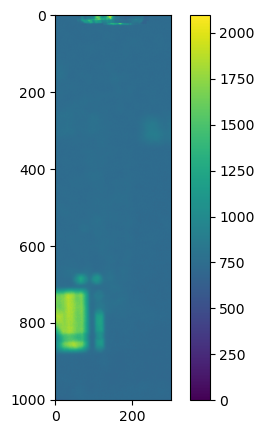

In [183]:
iframes_burner,no_frames_burner = sif_reader.np_open(r'mae\burner\burner.sif')
burner      = np.mean(iframes_burner,axis=0)
##%matplotlib widget
plt.figure(figsize= (5,5))
# plt.imshow(burner)}
fondo = 630#np.max(burner[900:950,10:150])#
burner_new = burner
burner_new[burner<fondo] = 0
plt.imshow(burner_new);plt.colorbar()

burner_aux = []
for i in range(np.shape(burner)[0]):
    for j in range(np.shape(burner)[1]):
        if burner_new[i,j] > 0:
            burner_aux.append((i,j))

burner_aux = np.array(burner_aux)

x1_burner = np.amin(burner_aux, axis = 0)[1]#51
x2_burner = np.amax(burner_aux, axis = 0)[1]#224
x_center = int((x1_burner+x2_burner)/2)#152#146# ### IMPORTANTE PORQUE DETERMINA DONDE SE ELIGEN LAS IMAGENES.
yor_burner = 30#26
print(x_center)

# S e I

In [184]:
### load experimental images
dct_1 = {}
x1_flame = 120
x2_flame = 160

if load_SIF == 1:
    for ii in range(len(lamb)):
        print(lamb[ii])
        S_fold = f'{folder_MAE}/{str(lamb[ii])}/S.sif'#!!!! Comentario Claudio: Cambié la estructura de la carpeta para que sea mas visual al momento de cargarlos. 
        data, info = sif_reader.np_open(S_fold)
        S_aux,S1_aux,S_frames_aux,S1_frames_aux = load_sif(data)
        I_fold = f'{folder_MAE}/{str(lamb[ii])}/I.sif'
        data, info = sif_reader.np_open(I_fold)
        I_aux,I1_aux,I_frames_aux,I1_frames_aux = load_sif(data)

#        tau = np.divide(S-S1,I-I1)
#        dct_1['file_%s' % ii] = [S]

        if ii < 1: #!! Comentario Claudio: ¿No sería mejor inicializar estos afuera del ciclo for? 
            Nz, Ny, Nx = np.shape(data)
            S = np.zeros((Ny,Nx,len(lamb))) # llama con backlight
            S1 = np.zeros((Ny,Nx,len(lamb))) # llama sin backlight
            I = np.zeros((Ny,Nx,len(lamb))) # fondo con backlight
            I1 = np.zeros((Ny,Nx,len(lamb))) # fondo sin backlight
            tau = np.zeros((Ny,Nx,len(lamb)))

            tau_std = np.zeros((Ny,Nx,len(lamb)))
            S1_std = np.zeros((Ny,Nx,len(lamb)))             
        
        S[:,:,ii] = S_aux
        S1[:,:,ii] = S1_aux
        I[:,:,ii] = I_aux
        I1[:,:,ii] = I1_aux

        tau[:,:,ii] = np.divide(S[:,:,ii]-S1[:,:,ii],I[:,:,ii]-I1[:,:,ii])

        S_frames_aux,binarios_S = filtrado_llama(S_frames_aux,h_px,x_center,x1_flame,x2_flame,holgura)
        S1_frames_aux,binarios_S1 = filtrado_llama(S1_frames_aux,h_px,x_center,x1_flame,x2_flame,holgura)
        
        S_frames_aux[S_frames_aux == 0] = np.nan
        S1_frames_aux[S1_frames_aux == 0] = np.nan
        # frames_I[frames_I == 0] = np.nan
        # frames_I1[frames_I1 == 0] = np.nan

        S_frames_aux = np.fliplr(np.nanmean(S_frames_aux,axis=0))
        S1_frames_aux = np.fliplr(np.nanmean(S1_frames_aux,axis=0))
        
        # I_lam = np.fliplr(np.nanmean(frames_I,axis=0))
        # I1_lam = np.fliplr(np.nanmean(frames_I1,axis=0))
        
        tau_inst_aux = (S_frames_aux - S1_frames_aux) / (I_frames_aux - I1_frames_aux)
        tau_std_aux = np.std(tau_inst_aux,axis=0)
        S1_std[:,:,ii] = np.std(S1_frames_aux,axis=0)
        tau_std[:,:,ii] = tau_std_aux         
        #plt.imshow(tau)
        #plt.gca().invert_yaxis()

tau[tau>1] = 1

500
532
660
810


122 [0.41712914 0.40715245 0.3853352  0.37304149]


Text(0.5, 1.0, 'S')

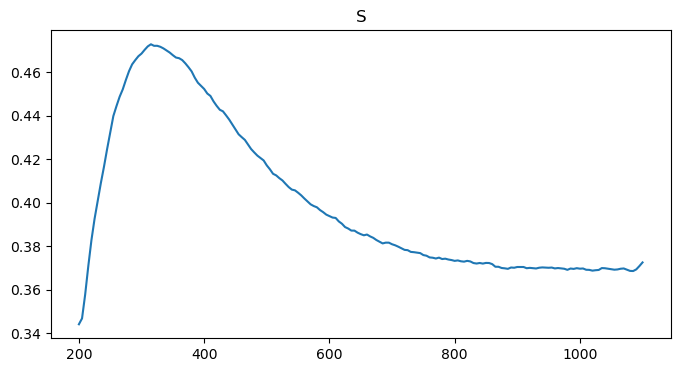

In [185]:
##  folder_MAE
# Folder Path
######path = r'D:\POSTDOC\EXPERIMENTOS\Gulder_flame_2021\MAE'
# Change the directory
# os.chdir(folder_MAE)
# Read text File

con1 = 0
#con3 = 0
dct_1 = {}
# iterate through all file
for file in os.listdir():
    # Check whether file is in text format or not
    if file.startswith('Em'):# and file.endswith('.DAT'): 
        con1 = con1 + 1
        file_path = os.path.join(file)#f"{folder_MAE}\{file}"
        dct_1['file_%s' % con1] = [file]
        Em_Yon = np.loadtxt(file_path)
        #Em_Yon = np.loadtxt(file_path, delimiter='  ')
Em_Yon[:,1] = savgol_filter(x = Em_Yon[:,1], window_length = 11, polyorder = 5)

E_m = np.zeros(len(lamb))
for ii in range(len(lamb)):
    aux = np.argmin(Em_Yon[:,0]<lamb[ii])
    E_m[ii] = Em_Yon[aux,1]
print(aux, E_m )

fig, (ax1) = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(8,4))
ax1.plot(Em_Yon[:,0],Em_Yon[:,1])
ax1.set_title('S')



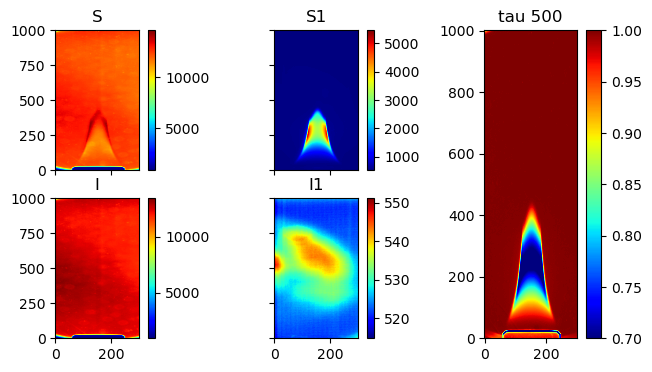

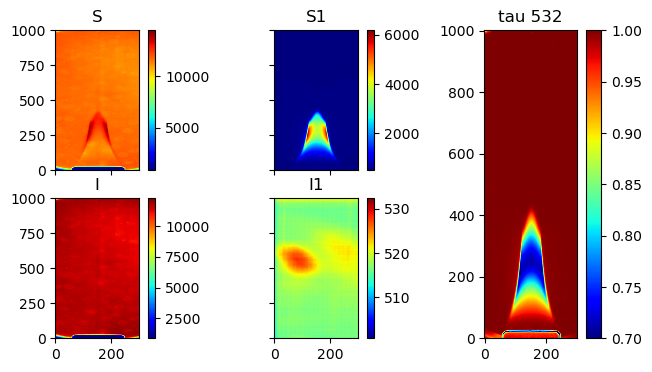

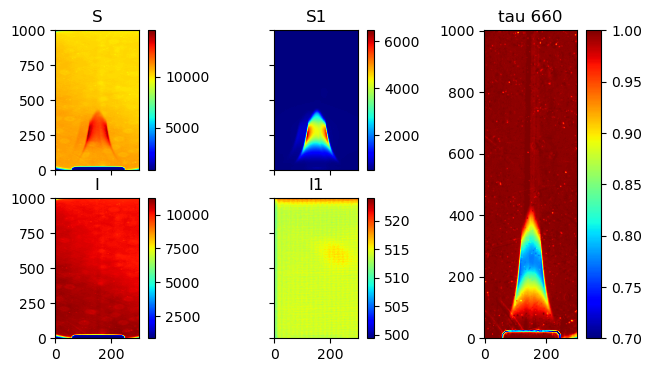

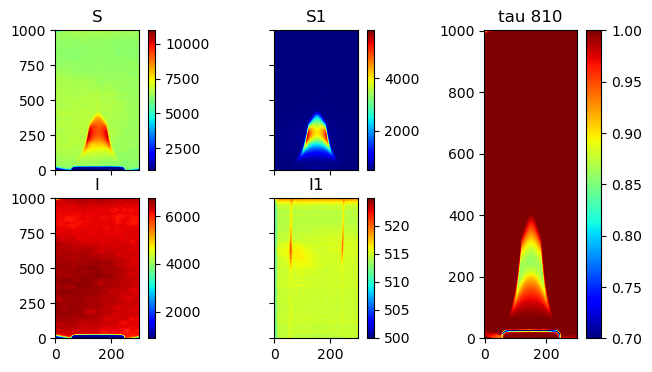

In [186]:
for ii in range(len(lamb)):
    fig, ((ax1, ax2, aux1), (ax3, ax4, aux2)) = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(8,4))
    #plot stuff on the axes
    im1 = ax1.imshow(S[:,:,ii] , cmap='jet', aspect=f_aspect)
    ax1.set_title('S')
    fig.colorbar(im1, ax=ax1)

    im2 = ax2.imshow(S1[:,:,ii] , cmap='jet', aspect=f_aspect)
    ax2.set_title('S1')
    fig.colorbar(im2, ax=ax2)

    im3 = ax3.imshow(I[:,:,ii] , cmap='jet', aspect=f_aspect)
    #im3 = ax3.imshow(S1_aux)
    ax3.set_title('I')
    fig.colorbar(im3, ax=ax3)

    im4 = ax4.imshow(I1[:,:,ii] , cmap='jet', aspect=f_aspect)
    ax4.set_title('I1')
    fig.colorbar(im4, ax=ax4)
    ax1.invert_yaxis()

    #turn rightmost 2 axes off
    aux1.axis("off")
    aux2.axis("off")
    #create a new subplot at their position
    ax5 = fig.add_subplot(133)
    im5 = ax5.imshow(tau[:,:,ii] , vmin=0.7, vmax=1, cmap='jet', aspect=1)
    ax5.set_title('tau '+str(lamb[ii]))
    fig.colorbar(im5, ax=ax5)
    ax5.invert_yaxis()

    plt.show()



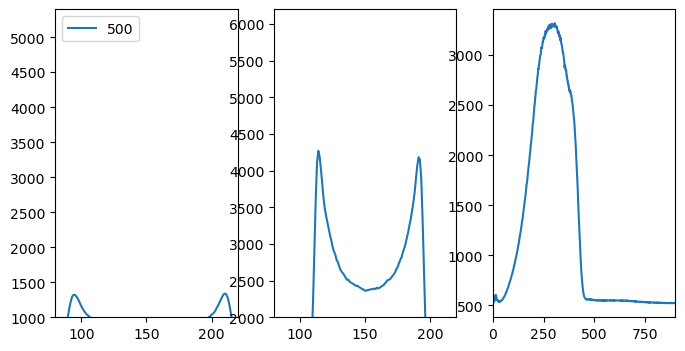

In [187]:
h1 = 100
h2 = 200
h3 = 300
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(8,4))
for ii in range(len(lamb)):
    #plot stuff on the axes
    ax1.plot(S1[h1,:,ii], label = str(lamb[ii]) )
    ax1.set_xlim([80, 220])
    ax1.set_ylim([1000, 5400])
    ax1.legend(loc='upper left')

    ax2.plot(S1[h2,:,ii] )
    ax2.set_xlim([80, 220])
    ax2.set_ylim([2000, 6200])

    ax3.plot(S1[:,150,ii] )
    ax3.set_xlim([0, 900])
    # ax3.set_ylim([1500, 4000])
    #ax1.invert_yaxis()

    plt.show()

# Calibracion

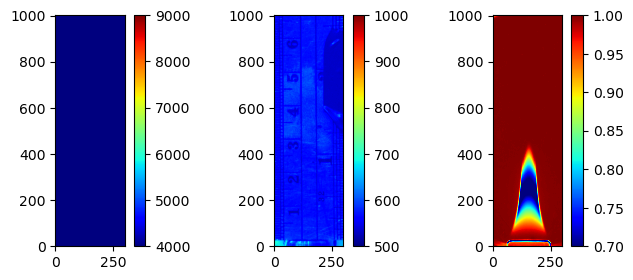

' fig, (ax1) = plt.subplots(1, 1, figsize=(8,3))\nplt.plot(tau[5,:,0]) '

In [188]:
# scale image
if load_calib == 1:
    dat_sca, info = sif_reader.np_open(folder_scale + '\\scale.sif')
    Nz_aux, Ny_aux, Nx_aux = np.shape(dat_sca)
    sca = np.zeros((Ny_aux, Nx_aux)) 
    cont = 0
    for ii in range (Nz_aux):
        cont = cont + 1
        sca = sca + dat_sca[ii,:,:]
    sca = sca / cont
    
    dat_ref, info = sif_reader.np_open(folder_scale + '\\ref.sif')
    Nz_aux, Ny_aux, Nx_aux = np.shape(dat_ref)
    ref = np.zeros((Ny_aux, Nx_aux)) 
    cont = 0
    for ii in range (Nz_aux):
        cont = cont + 1
        ref = ref + dat_ref[ii,:,:]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
im6 = ax1.imshow(ref, vmin=4000, vmax=9000, cmap='jet')
ax1.invert_yaxis()
fig.colorbar(im6, ax=ax1)
# ax1.set_ylim([12000, 14000])
#
im7 = ax2.imshow(sca, vmin=500, vmax=1000, cmap='jet')
fig.colorbar(im7, ax=ax2)
ax2.invert_yaxis()
#
im8 = ax3.imshow(tau[:,:,0], vmin=0.7, vmax=1, cmap='jet')
fig.colorbar(im8, ax=ax3)
ax3.invert_yaxis()
# ax5.invert_yaxis()

plt.show()

""" fig, (ax1) = plt.subplots(1, 1, figsize=(8,3))
plt.plot(tau[5,:,0]) """

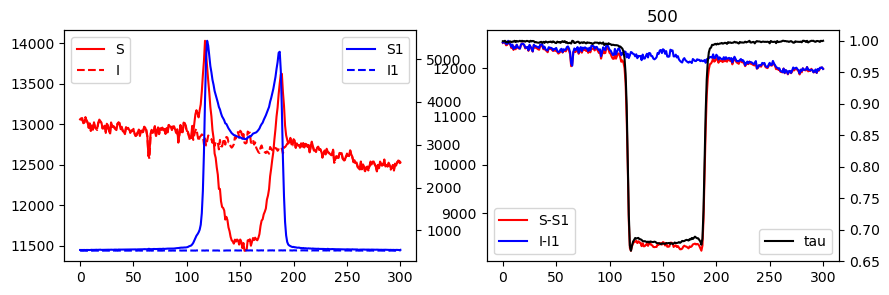

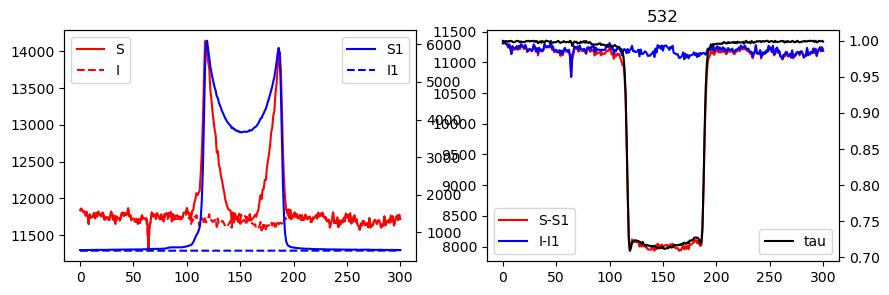

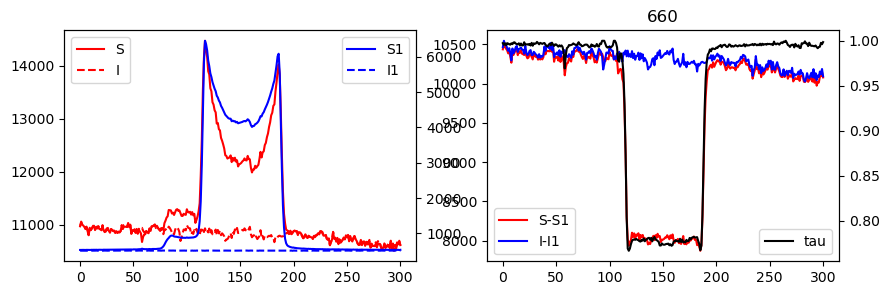

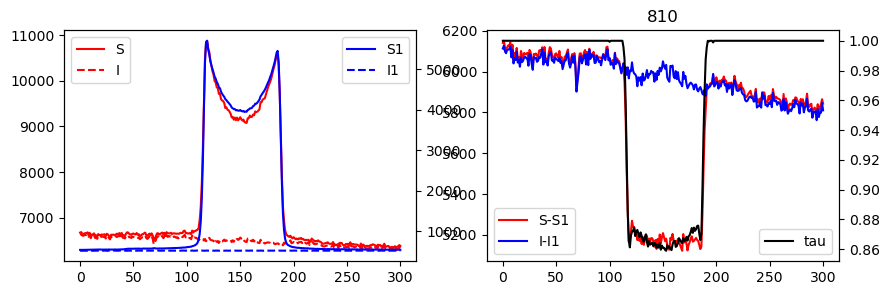

In [189]:


nx = np.linspace(0,Nx-1,Nx)
ny = np.linspace(0,Ny-1,Ny)

for ii in range(len(lamb)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    ax1.plot(S[h_px,:,ii], color='r', label='S')
    ax1.plot(I[h_px,:,ii], '--', color='r', label='I')
    ax12 = ax1.twinx()
    ax12.plot(S1[h_px,:,ii], color='b', label='S1')
    ax12.plot(I1[h_px,:,ii], '--', color='b', label='I1')
    ax1.legend(loc='upper left')
    ax12.legend(loc='upper right')
    # ax1.set_ylim([12000, 14000])

    ax2.plot(S[h_px,:,ii]-S1[h_px,:,ii], color='r', label='S-S1')
    ax2.plot(I[h_px,:,ii]-I1[h_px,:,ii], color='b', label='I-I1')
    ax22 = ax2.twinx()
    ax22.plot(tau[h_px,:,ii], color='k', label='tau')
    ax2.legend(loc='lower left')
    ax22.legend(loc='lower right')
    ax2.set_title(str(lamb[ii]))

    # ax3.imshow(tau, vmin=0.8, vmax=1, cmap='jet')
    # fig.colorbar(im5, ax=ax3)
    # ax3.invert_yaxis()
    # ax5.invert_yaxis()

    plt.show()

## Scaling

In [190]:
# scale image px/m
dr = abs(6-1)*1e-2 / np.sqrt((107-100)**2 + (901-173)**2)
Nmax = 80
# cut image
Zmin = 27
Zmax = 1002
offset_z = 0e-3
# Update the number of vertical pixels
nz = Zmax - Zmin + 1; 
r = np.linspace(0,Nmax,Nmax) * dr
z = np.linspace(0, Zmax-Zmin + 1, nz) * dr + offset_z
r_mm = r*1000
z_mm = z*1000

Tau = np.zeros(( nz,Nmax,len(lamb) )) 
Py = np.zeros(( nz,Nmax,len(lamb) ))
By = np.zeros(( nz,Nmax,len(lamb) ))

Tau_std = np.zeros(( nz,Nmax,len(lamb) ))
Py_std = np.zeros(( nz,Nmax,len(lamb) ))

### resize and image cutting
# Interval for find the center position of flame (r_px)
rcent = [120, 160]

if OI == '21': 
    displacement = [-2, -4, 3, 0, 0]#h_px = 400
elif OI == '23': 
    displacement = [0, 0, 0, 0, 0]##h_px = 400
elif OI == '25': 
    displacement = [-1, -6, 1, 0, 0]#h_px = 400
elif OI == '27': 
    displacement = [-2, -5, -3, 0, 0]#h_px = 200
elif OI == '29': 
    displacement = [0, 4, 1, 0, 0]#h_px = 200
elif OI == '31': 
    displacement = [0, 0, 0, 0, 0]#[-3, 0, 2, -2, 0]#h_px = 300
elif OI == '33': 
    displacement = [-1, -1, 0, 0, 0]#h_px = 200
elif OI == '35': 
    displacement = [0, 0, 0, 0, 0]#h_px = 200

#500 532 660 810 880

d_center = np.array([ [500,532,660,810,880], displacement, [0,0,0,0,0] ])

bb = np.zeros(( rcent[1]-rcent[0],len(lamb) ))
for ii in range(len(lamb)):
    i_disp = np.where( d_center[0,:] == lamb[ii] )[0][0]
    """ S1[:,:,ii] = rotate(S1[:,:,ii],d_center[2,i_disp]*math.pi/180,(0,148),(Ny,Nx))
    I1[:,:,ii] = rotate(I1[:,:,ii],d_center[2,i_disp]*math.pi/180,(0,148),(Ny,Nx))
    tau[:,:,ii] = rotate(tau[:,:,ii],d_center[2,i_disp]*math.pi/180,(0,148),(Ny,Nx))
 """
    bb[:,ii] = savgol_filter(S1[h_px,rcent[0]:rcent[1],ii],9,3)
    ccc = np.argmin(bb[:,ii], axis=0)     

    Rcenter = ccc + rcent[0] + round(d_center[1,i_disp])
    #print(d_center[1,i_disp])
    
    print( rcent[0] , round(d_center[1,i_disp]) , Rcenter )

    # Cuting the Tau and Emission imagen
    Tau[:,:,ii] = tau[Zmin-1:Zmax,Rcenter:Rcenter+Nmax,ii] 
    Py[:,:,ii] = S1[Zmin-1:Zmax,Rcenter:Rcenter+Nmax,ii]
    By[:,:,ii] = I1[Zmin-1:Zmax,Rcenter:Rcenter+Nmax,ii]

    Tau_std[:,:,ii] = tau_std[Zmin-1:Zmax,Rcenter:Rcenter+Nmax,ii]
    Py_std[:,:,ii] = S1_std[Zmin-1:Zmax,Rcenter:Rcenter+Nmax,ii]

np.save('r_mm',r_mm)
np.save('z_mm',z_mm)
print(len(z_mm),len(r_mm),Rcenter)

120 0 154
120 0 151
120 0 149
120 0 154
976 80 154


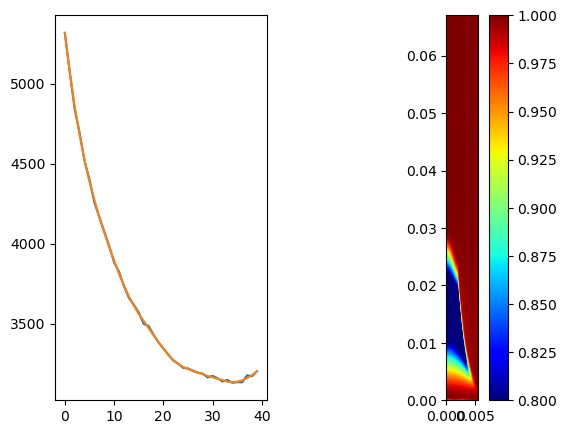

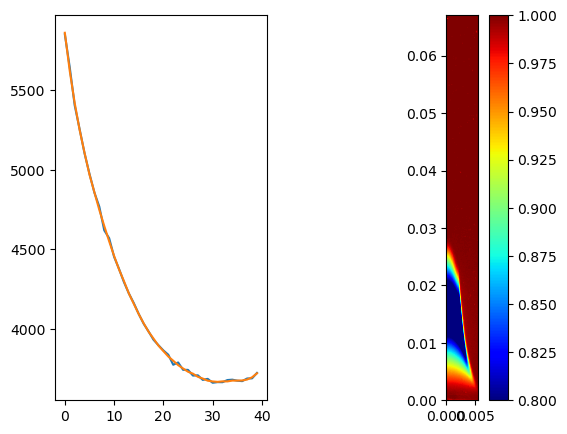

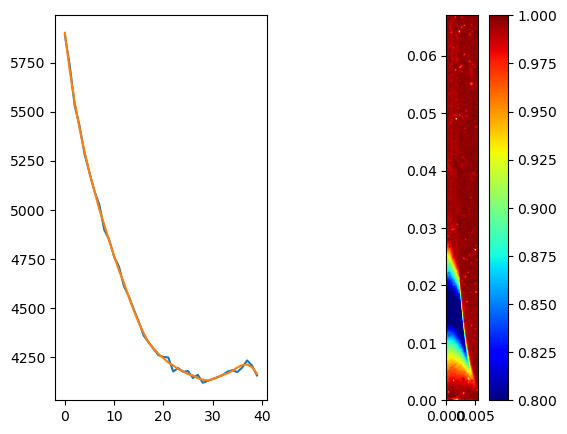

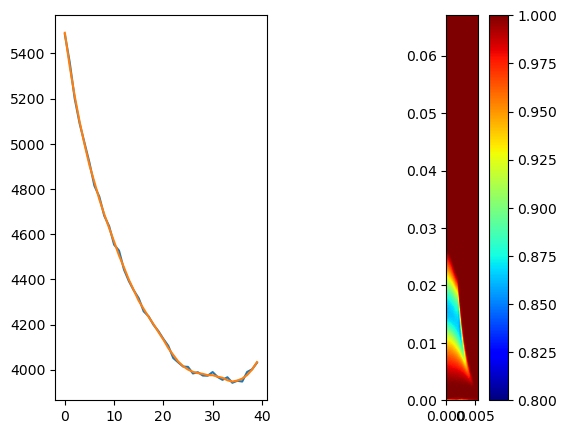

In [191]:
for ii in range(len(lamb)):
    fig, (ax,ax1) = plt.subplots(1,2, figsize=(6,5))
    ax.plot(S1[h_px,rcent[0]:rcent[1],ii])
    ax.plot(bb[:,ii])
    im3 = ax1.imshow(Tau[:,:,ii], cmap='jet', vmin=0.8, vmax=1,  extent =[r.min(), r.max(), z.max(),  z.min()])
    # 
    fig.colorbar(im3, ax=ax1)
    ax1.invert_yaxis()
    plt.show()

In [192]:
%matplotlib inline


In [193]:
# deconvolution

Aop = Aop_matrix(Nmax,dr)

Lo = np.zeros((Nmax-1,Nmax))
for ii in range (1,Nmax):
    Lo[ii-1,ii-1] = 1
    Lo[ii-1,ii] = -1

kext = np.zeros(( nz,Nmax,len(lamb) ))
kext0 = np.zeros(( nz,Nmax,len(lamb) ))
fv = np.zeros(( nz,Nmax,len(lamb) ))
fv0 = np.zeros(( nz,Nmax,len(lamb) ))
#E_m = np.zeros(len(lamb))

for ii in range(len(lamb)):
    OP = - np.log(Tau[:,:,ii])	# Optical path
    for hab in range(nz):
        print(hab)
        cc = OP[hab,:]    
        kext0[hab,:,ii], kext[hab,:,ii] = Deconvolution(Lo,Aop,cc,alfa_o)
    # E_m function
    #E_m[ii] = Em_function(lamb[ii]*1e-3,2); # soot absorption function
    fv0[:,:,ii] = kext0[:,:,ii]*lamb[ii]*1e-9 / (6*math.pi*E_m[ii]*(1+rho_sa))  # soot volume fraction (ppm)
    fv[:,:,ii]  = kext[:,:,ii]*lamb[ii]*1e-9 / (6*math.pi*E_m[ii]*(1+rho_sa))  # soot volume fraction (ppm)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

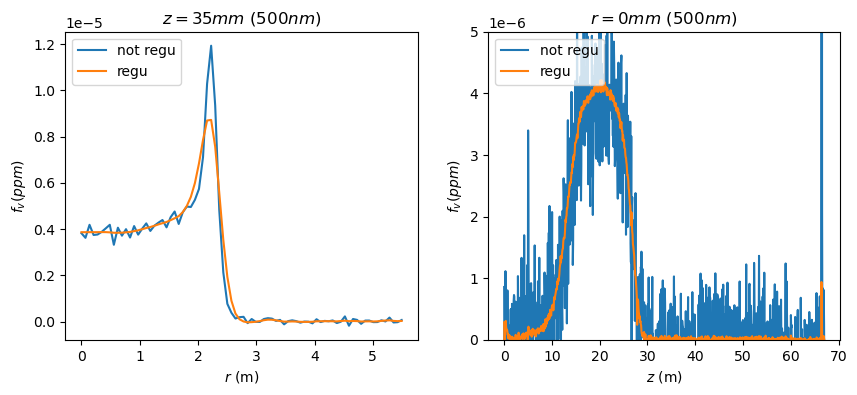

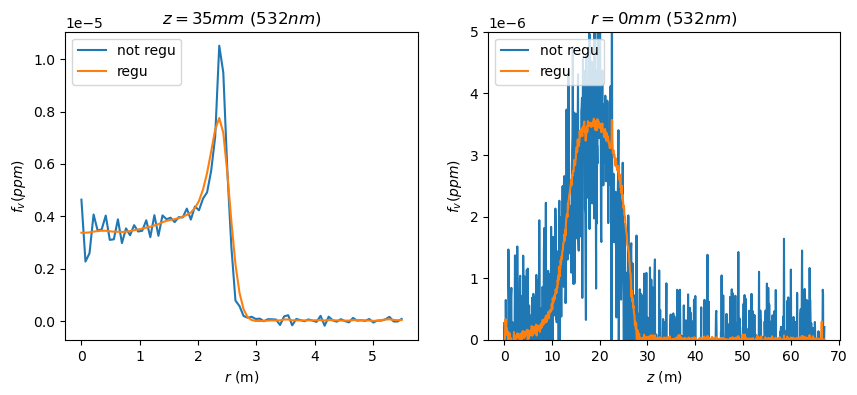

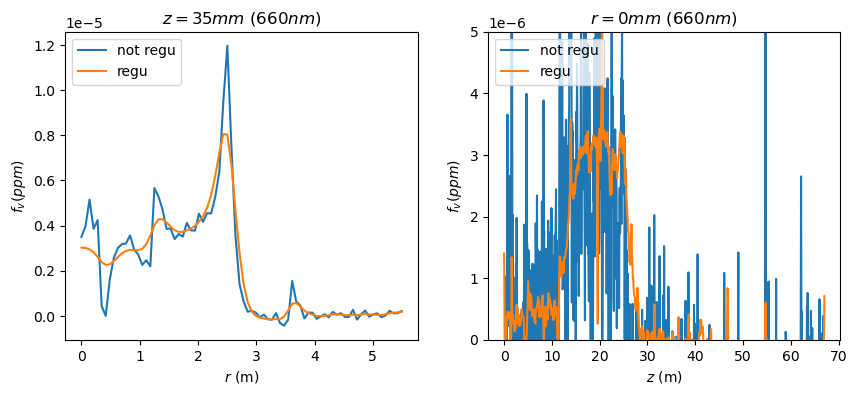

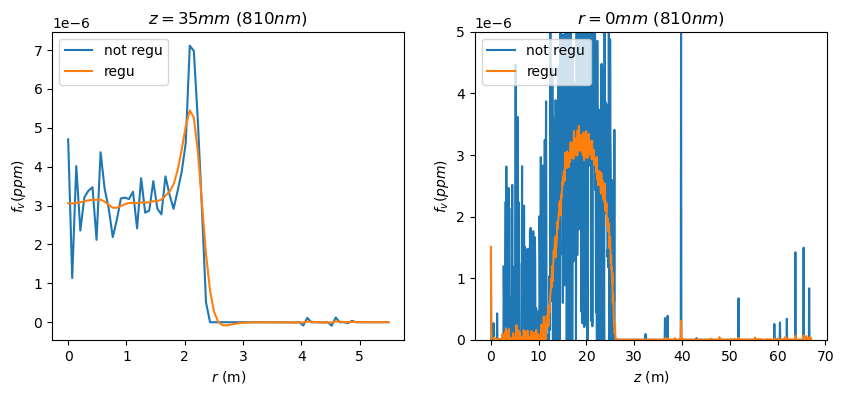

In [194]:
fv_lim = 5e-6
h_mm = 35
# h_px = np.argmax(z_mm>h_mm)

lim_fv = 0.3e-6
fv_aux = fv[:,:,0]#1
for ii in range(len(lamb)):
    kext[:,:,ii][fv_aux < lim_fv] = 0
    Py[:,:,ii][fv_aux < lim_fv] = 0
    Py_std[:,:,ii][fv_aux < lim_fv] = 0
    By[:,:,ii][fv_aux < lim_fv] = 0

    Tau[:,:,ii][fv_aux < lim_fv] = 0
    Tau_std[:,:,ii][fv_aux < lim_fv] = 0

### figure
for ii in range(len(lamb)):
    ifig += 1
    fig, (ax3,ax4) = plt.subplots(1,2, figsize=(10,4))
    ax3.plot(r_mm,fv0[h_px,:,ii], label='not regu')
    ax3.plot(r_mm,fv[h_px,:,ii], label='regu')
    plt.ylim([0, fv_lim])
    ax3.set_title(r'$z='+str(h_mm)+'mm~('+str(lamb[ii]) + r'nm)$')
    ax3.legend(loc='upper left')
    #ax3.axes.set_aspect('equal')
    ax3.set_xlabel(r'$r$ (m)')
    ax3.set_ylabel(r'$f_v (ppm)$ ')
    #
    ax4.plot(z_mm,fv0[:,0,ii], label='not regu')
    ax4.plot(z_mm,fv[:,0,ii], label='regu')
    plt.ylim([0, fv_lim])
    ax4.set_title(r'$r=0mm~('+str(lamb[ii]) + r'nm)$')
    ax4.legend(loc='upper left')
    ax4.set_xlabel(r'$z$ (m)')
    ax4.set_ylabel(r'$f_v (ppm)$ ')
    if save_data == 1:
        plt.savefig(folder_LOSA + r'/fv_profiles_'+str(lamb[ii])+'nm_alpha='+str(alfa_o)+'.png', dpi=300)#(os.path.join(folder_LOSA, 'fv_profiles_'+str(lamb[ii])+'nm_alpha='+str(alfa_o)+'.png')

    plt.show()

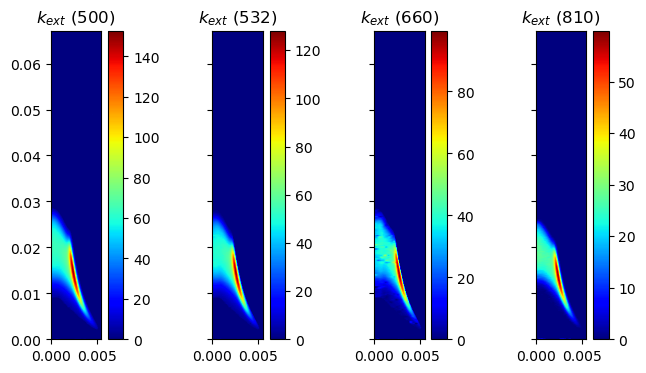

In [195]:
### figure
fig, axs = plt.subplots(1,len(lamb), sharex=True, sharey=True, figsize=(2*len(lamb),4))
for ii in range(len(lamb)):    
    im = axs[ii].imshow(kext[:,:,ii], vmin = 0, vmax= np.max(kext[:,:,ii]),  cmap='jet', aspect=f_aspect, extent =[r.min(), r.max(), z.max(),  z.min()])
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$k_{ext}~(' + str(lamb[ii]) + r')$' )
plt.show
if save_data == 1:
    plt.savefig(folder_LOSA + r'\fields_kext'+str(lamb)+'nm_alpha='+str(alfa_o)+'.png', dpi=300)

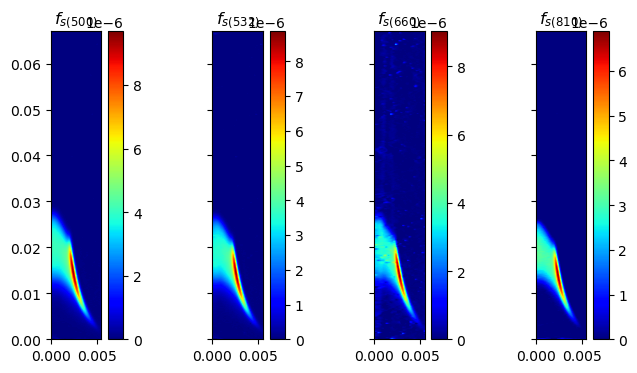

In [196]:
fig, axs = plt.subplots(1,len(lamb), sharex=True, sharey=True, figsize=(2*len(lamb),4))
for ii in range(len(lamb)):    #fv_lim
    im = axs[ii].imshow(fv[:,:,ii], vmin=0, vmax=np.max(fv[:,:,ii]), cmap='jet', aspect=f_aspect, extent =[r.min(), r.max(), z.max(),  z.min()])
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$f_{s (' + str(lamb[ii]) + r')}$' )
plt.show()
if save_data == 1:
    plt.savefig(folder_LOSA + r'\fields_fv'+str(lamb)+'nm_alpha='+str(alfa_o)+'.png', dpi=300)

In [197]:
hab_20 = np.where(z>20/1000)[0][0]
hab_30 = np.where(z>30/1000)[0][0]
hab_40 = np.where(z>40/1000)[0][0]
hab_50 = np.where(z>50/1000)[0][0]
print(hab_20)

291


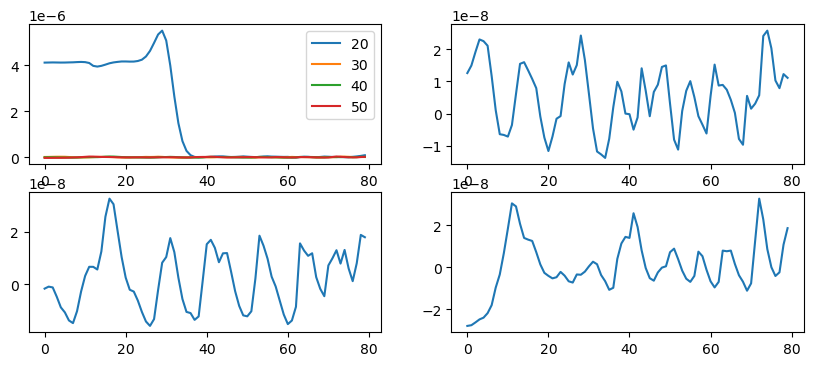

In [198]:
fig, ((ax6,ax7),(ax8,ax9)) = plt.subplots(2,2, figsize=(10,4))
ax6.plot(fv[hab_20,:,0],label="20")
ax6.plot(fv[hab_30,:,0],label="30")
ax6.plot(fv[hab_40,:,0],label="40")
ax6.plot(fv[hab_50,:,0],label="50")

ax6.legend(loc='best')

ax7.plot(fv[hab_30,:,0])

ax8.plot(fv[hab_40,:,0])

ax9.plot(fv[hab_50,:,0])

## k ext

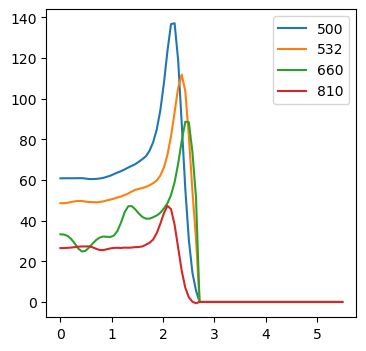

In [199]:
#lim_fv = 0.1e-6
fig, ax = plt.subplots(1,1, figsize=(4,4))
for ii in range(len(lamb)):
    #fv_1 = fv[h_px,:,ii]
    #kext[h_px,:,ii][fv_1 < lim_fv] = 0
    ax.plot(r_mm,kext[h_px,:,ii], label=str(lamb[ii]))
    #ax.plot(r_mm,kext0[h_px,:,ii], label='not regu')
ax.legend(loc='upper right')

plt.show()

fv max


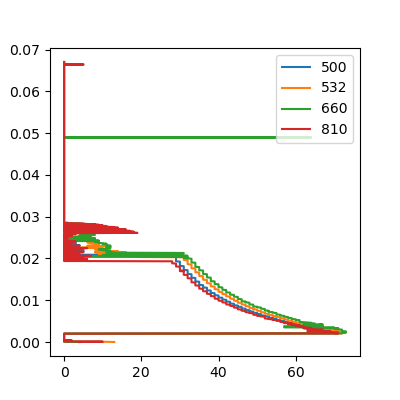

In [200]:
%matplotlib widget
i_fvsoot = np.zeros((nz,len(lamb)))

for kk in range(len(lamb)):
    for ii in range(nz):
        i_fvsoot[ii,kk] = np.where(kext[ii,:,kk] == np.max(kext[ii,:,kk]))[0][0]
#    
fig, ax = plt.subplots(1,1, figsize=(4,4))
for ii in range(len(lamb)):
    ax.plot(i_fvsoot[:,ii],z, label=str(lamb[ii]))
ax.legend(loc='upper right')

plt.show()

In [201]:
# asd 
if save_data == 1:
    #!! Comentarios Claudio: Cambié un poco el el string para guardar el archivo
    np.savez(f'{folder_LOSA}/Losa_{lamb}nm_alpha={alfa_o}.npz',name_Py_std=Py_std,name_Tau_std=Tau_std,name_Py=Py,name_By=By,name_kext=kext,name_fv=fv,name_r=r,name_z=z)
    np.savez(f'{folder_LOSA}/Losa_{lamb}nm_alpha={alfa_o}_Tau_S1_std.npz',name_Py_std=Py_std,name_Tau_std=Tau_std,name_Py=Py,name_Tau=Tau)
    # np.savez(folder_LOSA + '\Losa_'+str(lamb)+'nm_alpha='+str(alfa_o)+'.npz',name_Py_std=Py_std,name_Tau_std=Tau_std,name_Py=Py,name_By=By,name_kext=kext,name_fv=fv,name_r=r,name_z=z)
    # np.savez(folder_LOSA + '\Losa_'+str(lamb)+'nm_alpha='+str(alfa_o)+'_Tau_S1_std'+'.npz',name_Py_std=Py_std,name_Tau_std=Tau_std,name_Py=Py,name_Tau=Tau)

# K_ext MC

In [202]:
activate_MC = 1
def my_makedirs(path):
    if not os.path.isdir(path):
        print(f'path {path} created')
        os.makedirs(path)

if activate_MC == 1:
    Tau_mean = Tau
    Tau_std = Tau_std
    Py_std = Py_std
    Py_mean = Py
    r_2D = r
    z_2D = z
    nz = len(z_2D)
    nx = len(r_2D)
    resol = 1/(r_2D[1]-r_2D[0])

    Tau_MC = np.zeros((np.shape(Tau_mean)[0],np.shape(Tau_mean)[1],np.shape(Tau_mean)[2],N_int))
    Py_MC = np.zeros_like(Tau_MC)
    # Set the random normal with shape of 976,80,n_MC. All lambdas should have the same variance for beta
    np.random.seed(1)
    Noise_tau = np.random.normal(0,1,(np.shape(Tau_mean)[0],np.shape(Tau_mean)[1],N_int))
    np.random.seed(2)
    Noise_Py = np.random.normal(0,1,(np.shape(Py_mean)[0],np.shape(Py_mean)[1],N_int))
    for i in range(len(lamb)):
        for NN in range(N_int):
            Tau_MC[:,:,i,NN] = Tau_mean[:,:,i] + Tau_std[:,:,i]*Noise_tau[:,:,NN]
            Py_MC[:,:,i,NN] = Py_mean[:,:,i] + Py_std[:,:,i]*Noise_Py[:,:,NN]

    kext_MC = np.zeros((nz,nx,len(lamb),N_int))
    for i in range(len(lamb)):
        tau = Tau_MC[:,:,i,:] 
        # tau[np.isnan(tau)] = 0       
        Py_lambd = - np.log(tau) # Optical path
        Py_lambd[np.isinf(Py_lambd)] = 0
        Py_lambd[np.isneginf(Py_lambd)] = 0
        Py_lambd[np.isnan(Py_lambd)] = 0
        dr = 1/resol#resol**-1 # radial resolution meter/pixel
        Self_abs = 0
        kext = np.zeros_like(Py_lambd)#((nz,nx,N_int))
        kext,kext0,alfa = deconvolution_Py_MC(dr,alfa_o,Py_lambd,AUTOalfa,Self_abs,kext)    
        kext_MC[:,:,i,:] = kext
        print(i)

    std_kext = np.std(kext_MC, axis=3)
    mean_kext = np.mean(kext_MC, axis=3)

    # for i in [21, 23, 25, 27, 29, 31, 33, 35]:
    #     Path(f"MC_{N_int}/{i}").mkdir(parents=True, exist_ok=True)

    path_mean_kext = os.path.join('results_MC', 'MC_10012023', OI,  'mean_kext')
    path_std_kext = os.path.join('results_MC', 'MC_10012023', OI, 'std_kext')
    my_makedirs(path_mean_kext)
    my_makedirs(path_std_kext)
    np.save(path_mean_kext,mean_kext)
    np.save(path_std_kext,std_kext)
    # if save_data ==1:
    #     np.save(f'MC_{N_int}/{OI}/mean_kext_MC',mean_kext)
    #     np.save(f'MC_{N_int}/{OI}/std_kext_MC',std_kext)
    #     np.save(f'MC_{N_int}/{OI}/field_kext_MC',kext_MC)

C:\Users\claud\AppData\Local\Temp\ipykernel_16972\3701485517.py:34: RuntimeWarning: divide by zero encountered in log
  Py_lambd = - np.log(tau) # Optical path


0


C:\Users\claud\AppData\Local\Temp\ipykernel_16972\3701485517.py:34: RuntimeWarning: divide by zero encountered in log
  Py_lambd = - np.log(tau) # Optical path


1
2
3
path results_MC\MC_10012023\35\mean_kext created
path results_MC\MC_10012023\35\std_kext created


### Kext MC nuevo

In [203]:
activate_MC = 0
Comentarios_iteraciones = False#True
print('OI Used: {0}'.format(OI))
if activate_MC == 1:
    Tau_mean = Tau
    Tau_std = Tau_std
    Py_std = Py_std
    Py_mean = Py
    r_2D = r
    z_2D = z
    nz = len(z_2D)
    nx = len(r_2D)
    resol = 1/(r_2D[1]-r_2D[0])

    #? Tau.shape = nz,nr,lambd

    Tau_MC = np.zeros((np.shape(Tau_mean)[0],np.shape(Tau_mean)[1],np.shape(Tau_mean)[2],N_int))
    Py_MC = np.zeros_like(Tau_MC)
    Noise_tau = np.random.normal(0,1,(np.shape(Tau_mean)[0],np.shape(Tau_mean)[1],np.shape(Tau_mean)[2],N_int))
    Noise_Py = np.random.normal(0,1,(np.shape(Py_mean)[0],np.shape(Py_mean)[1],np.shape(Py_mean)[2],N_int))
    for i in range(len(lamb)):
        for NN in range(N_int):
            Tau_MC[:,:,i,NN] = Tau_mean[:,:,i] + Tau_std[:,:,i]*Noise_tau[:,:,i,NN]
            Py_MC[:,:,i,NN] = Py_mean[:,:,i] + Py_std[:,:,i]*Noise_Py[:,:,i,NN]

    kext_MC = np.zeros((nz,nx,len(lamb),N_int))

    #? Tau.shape = nz,nr,lambd,N_int
    #? Py_lambd.shape = nz,nr,lambd,N_int
    tau_aux = Tau_MC[:,:,:,:] 
    # tau[np.isnan(tau)] = 0       
    Py_lambd = - np.log(tau_aux) # Optical path
    Py_lambd[np.isinf(Py_lambd)] = 0
    Py_lambd[np.isneginf(Py_lambd)] = 0
    Py_lambd[np.isnan(Py_lambd)] = 0
    dr = 1/resol#resol**-1 # radial resolution meter/pixel
    Self_abs = 0
    kext = np.zeros_like(Py_lambd)#((nz,nx,lambd,N_int))
    kext,kext0,alfa = new_deconvolution_Py_MC(dr,alfa_o,Py_lambd,AUTOalfa,Self_abs,kext,Comentarios_iteraciones)    
    kext_MC[:,:,:,:] = kext
    # print(i)

    std_kext = np.std(kext_MC, axis=3)
    mean_kext = np.mean(kext_MC, axis=3)
    # np.save(os.path.join('results_MC', 'MC', OI, 'mean_kext_MC'),mean_kext)
    # np.save(os.path.join('results_MC', 'MC', OI, 'std_kext_MC'),std_kext)
    # np.save(os.path.join('results_MC', 'MC', OI, 'field_kext_MC'),kext_MC)

    # % Se crea una carpeta para cada condición de OI. Si esta ya existe, entonces no se crea y continua.
    for i in [21, 23, 25, 27, 29, 31, 33, 35]:
        Path(f"MC_{N_int}/{i}/Load").mkdir(parents=True, exist_ok=True)

    if save_data == 1:
        np.save(f'MC_{N_int}/{OI}/mean_kext_MC',mean_kext)
        np.save(f'MC_{N_int}/{OI}/std_kext_MC',std_kext)
        np.save(f'MC_{N_int}/{OI}/field_kext_MC',kext_MC)


OI Used: 35


In [204]:
%matplotlib inline

def plot_pdf_kext(i_z,i_r,i_lambd):
       fig, ax = plt.subplots(1,2, figsize=(8,3))
       mu = mean_kext[i_z,i_r,i_lambd]
       sigma = std_kext[i_z,i_r,i_lambd]
       test = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
       # test = np.linspace(stats.norm.ppf(0.01),
       #                 stats.norm.ppf(0.99), 100)
       ax[0].plot(test, stats.norm.pdf(test, mu, sigma),
              'r-', lw=5, alpha=0.6, label='norm pdf')
       ax[1].contourf(r,z,std_kext[:,:,i_lambd], levels = np.linspace(0,5,10))
       ax[1].plot(r[i_r],z[i_z],'s', color = 'red')
       plt.show()

In [205]:
i_z_widget = widgets.IntSlider(min=0, max= 975, step=1, value=0)
i_r_widget = widgets.IntSlider(min=0, max= 80, step=1, value=0)
i_l_widget = widgets.IntSlider(min=0, max= 3, step=1, value=0)

widgets.interact(plot_pdf_kext, i_z = i_z_widget, i_r = i_r_widget, i_lambd = i_l_widget)

interactive(children=(IntSlider(value=0, description='i_z', max=975), IntSlider(value=0, description='i_r', ma…

<function __main__.plot_pdf_kext(i_z, i_r, i_lambd)>

# Temperatrure

In [206]:
C1 = 3.7418e-16   # 2*pi*hc**2
kb      = 1.38064852e-23 # boltzmann
h_planck= 6.62607004e-34 # planck
c_light = 299792458      # speed of light
C2 = 1.4388e-2	# hc/k_B Planck constants S.I.

side = 0   	   # Image side	0:left;	1:right 
AUTOalfa = 0   # Alpha parameter method	0:constante;	1:automatic
alfa_o = 5e-6 # If Alpha regul. constante                    
E_ref = 2      # Abs. funct. Model	1:Chang; 2:Jérôme Yon; 3:Krishnan
rho_sa = 0     # Scatering factor  0.16 (Sneling at 450 nm)  
smooth_tau = 0 # 1: apply vertical smooth for transmissivity field
plot_FIG = 1   # 1: plot figures results
lim_fv = 0.005e-6
# h_px = 600     # Select an height for procedure verification in px 
Self_abs = 1  #  
save_data = 0 # 1: save_computed_fv_data_and_figures
ifig = 1
f_aspect = 0.5

folder_Losa_result = os.path.join(folder_LOSA,'Losa_[500, 532, 660, 810]nm_alpha=3e-06.npz')#r'Losa_results\Losa_[500, 532, 660, 810]nm_alpha=3e-06.npz'
folder_calib = r'Calibration_LUCA_10_12_2021'
# folder_calib = r'G:\My Drive\EC2G\Doctorado\Experimentos\PCI 2022\jet_fuel\Medidas_291121\mae\Calibration_LUCA_10_12_2021'

folder_PYR = r'Pyro_results' 
folder_PYR = os.path.join(folder_PYR,OI)

<function matplotlib.pyplot.show(close=None, block=None)>

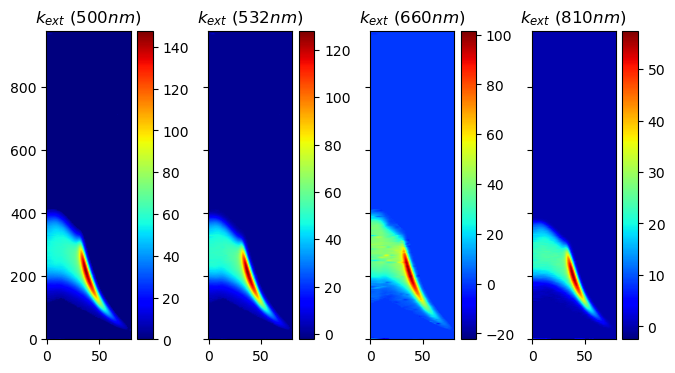

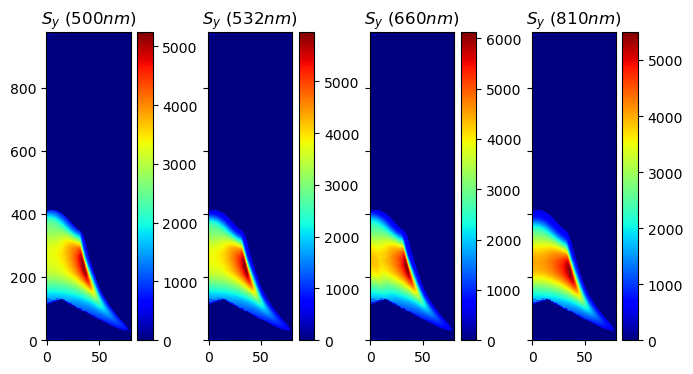

In [207]:
### load experimental images

aux = np.load(folder_Losa_result) # load
By = aux['name_By']
Sy = aux['name_Py']
r = aux['name_r']
z = aux['name_z']
fv = aux['name_fv']
Kext = aux['name_kext']
fv_1 = fv[:,:,0]
#Kext_1 = Kext[:,:,0]
nx = len(r)
nz = len(z)
Sy_aux = np.zeros((nz,nx,len(lamb)))
for ii in range(len(lamb)):
    Sy_aux[:,:,ii] = Sy[:,:,ii] - By[:,:,ii]
    Sy_aux[:,:,ii][fv_1 < lim_fv] = 0

### figure
fig, axs = plt.subplots(1,len(lamb), sharex=True, sharey=True, figsize=(2*len(lamb),4))
for ii in range(len(lamb)):    
    im = axs[ii].imshow(Kext[:,:,ii], cmap='jet', aspect=0.3)
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$k_{ext}~(' + str(lamb[ii]) + r'nm)$' )
plt.show

### figure
fig, axs = plt.subplots(1,len(lamb), sharex=True, sharey=True, figsize=(2*len(lamb),4))
for ii in range(len(lamb)):    
    im = axs[ii].imshow(Sy[:,:,ii], cmap='jet', aspect=0.3)
    fig.colorbar(im, ax=axs[ii])
    
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$S_{y}~(' + str(lamb[ii]) + r'nm)$' )
plt.show

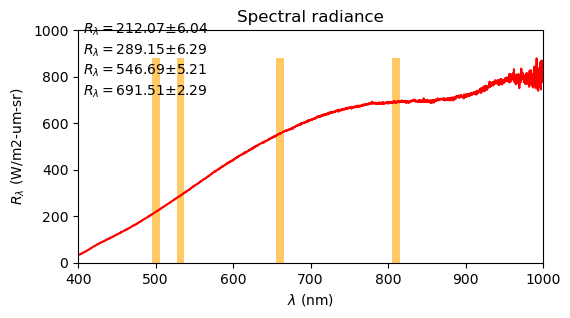

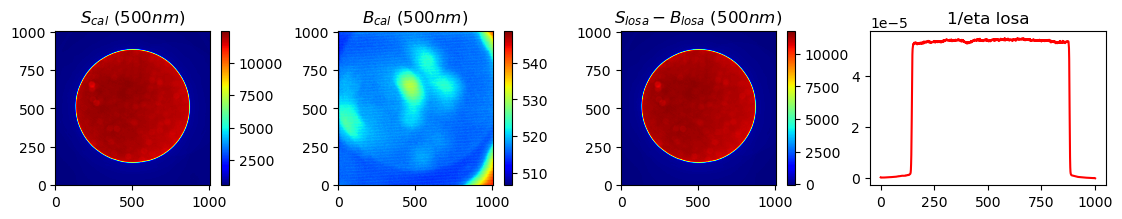

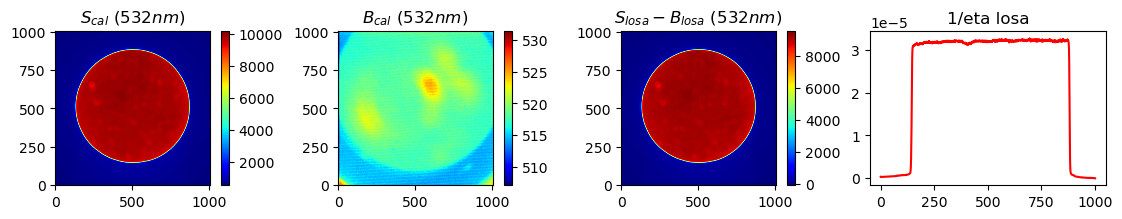

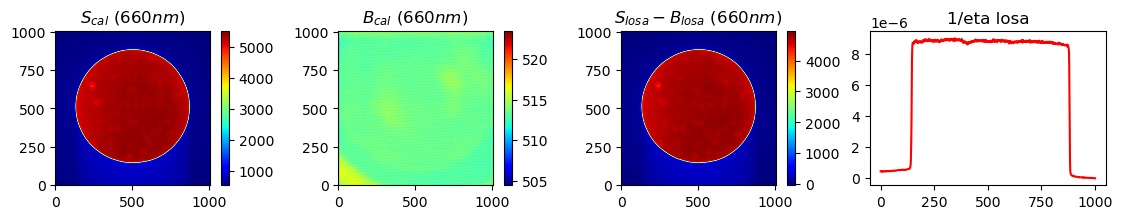

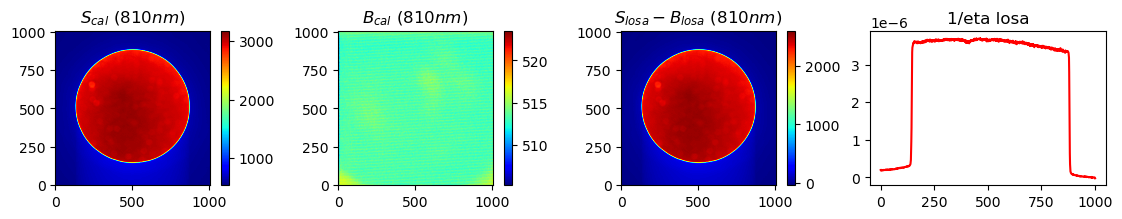

In [208]:
### Spectrometer
### -------------
folder_spec = folder_calib + r'\Calibración_10_12_2021_LUCA.csv'#r'\Spectrometro_05_10_2021.csv'#


def load_sif_cal(data_aux):
    nz, ny, nx = np.shape(data_aux)
    #[nz,ny,nx]= np.shape(data)
    S = np.zeros((ny,nx))
    S_frames = np.zeros((nz,ny,nx))
    cont_1 = -1
    for jj in range(nz):
        cont_1 = cont_1 + 1
        S_frames[cont_1,:,:] = data_aux[jj,:,:]
        S = S + data_aux[jj,:,:]
    S = np.divide(S,(cont_1+1))
    return S,S_frames


file = open(folder_spec)
speclines = np.loadtxt(file, delimiter=',', skiprows=2)
mean_R = np.zeros(len(lamb))
std_R = np.zeros(len(lamb))

lamb_filters = np.array([497,532,655,810]) # Inputs

for ii in range(len(lamb)):
    a = np.argmin(lamb_filters[ii]-5>speclines[:,0])
    b = np.argmin(lamb_filters[ii]+5>speclines[:,0])
    mean_R[ii] = np.mean(speclines[a:b,1])
    std_R[ii] = np.std(speclines[a:b,1])

### figure
fig, ax1 = plt.subplots(1,1, figsize=(6,4))      
ax1.plot(speclines[:,0],speclines[:,1], c='red')
ax1.set_xlim([400, 1000])
ax1.set_ylim([0, 1000])
ax1.axes.set_aspect(0.3)
ax1.set_title('Spectral radiance')
ax1.set_xlabel(r'$\lambda$ (nm)')
ax1.set_ylabel(r'$R_{\lambda}$ (W/m2-um-sr)')
contt = 220 
dlamb = np.array([10, 10])
for ii in range(len(mean_R)):
    contt = contt - 15
    ax1.annotate(r'$R_{\lambda}=$'+str(round(mean_R[ii],2)) + '$\pm$' + str(round(std_R[ii],2)) , xy=(60, contt), xycoords='figure points')
    ax1.fill_between((lamb[ii]-0.5*dlamb[1],lamb[ii]+0.5*dlamb[1]), 0, np.max(speclines[:,1]), facecolor='orange', alpha=0.6) # blocked area for second axes
if save_data == 1:
    plt.savefig(folder_PYR+'/Spect_Calib.png', dpi=300)

### Calibration
# if OI == '21' or OI == '23' or OI == '25' or OI == '27': #Calibracion antigua
#     texp = np.array([ [500,532,660,810,880], [125,70,13,13,13] ])

# if OI == '29' or OI == '31' or OI == '33' or OI == '35' or OI == '37': #Calibracion nueva, va con filtro adicional con el cual no esta calibrado
#     texp = np.array([ [500,532,660,810,880], [100,50,13,13,13] ])
texp = np.array([ [500,532,660,810,880], [125,70,13,13,13] ])

### img

i_texp = np.zeros(len(lamb))
S_cal = np.zeros((1002,1004,len(lamb)))
B_cal = np.zeros((1002,1004,len(lamb)))
delta_cal = np.zeros((1002,1004,len(lamb)))
eta_losa = np.zeros((1002,1004,len(lamb)))
auxxx = np.zeros((1002,1004,len(lamb)))
for ii in range(len(lamb)):
    a = np.where( texp[0,:] == lamb[ii] )[0][0]
    data, info = sif_reader.np_open(folder_calib+ '\\' + str(lamb[ii]) + '_' + str(texp[1,a]) +'.sif')
    S_cal[:,:,ii], Scal_frames = load_sif_cal(data)
    data, info = sif_reader.np_open(folder_calib+ '\\' + str(lamb[ii]) + '_' + str(texp[1,a]) +'_BG.sif')
    B_cal[:,:,ii], Bcal_frames = load_sif_cal(data)
    delta_cal[:,:,ii] = S_cal[:,:,ii] - B_cal[:,:,ii]
    # auxxx[auxxx < 0] = 0
    # delta_cal[:,:,ii] = auxxx
    delta_cal[:,:,ii] = delta_cal[:,:,ii] - np.mean(delta_cal[800:900,100:200,ii])
    eta_losa[:,:,ii] = np.divide( mean_R[ii]*1e6 , delta_cal[:,:,ii] )

### figure
for ii in range(len(lamb)):
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(14,2))
    im1 = ax1.imshow(S_cal[:,:,ii], cmap='jet', aspect=1)
    fig.colorbar(im1, ax=ax1)
    ax1.invert_yaxis()
    ax1.set_title(r'$S_{cal}~(' + str(lamb[ii]) + r'nm)$' )
    #
    im2 = ax2.imshow(B_cal[:,:,ii], cmap='jet', aspect=1)
    fig.colorbar(im2, ax=ax2)
    ax2.invert_yaxis()
    ax2.set_title(r'$B_{cal}~(' + str(lamb[ii]) + r'nm)$' )
    #
    im3 = ax3.imshow(delta_cal[:,:,ii], cmap='jet', aspect=1)
    fig.colorbar(im3, ax=ax3)
    ax3.invert_yaxis()
    ax3.set_title(r'$S_{losa}-B_{losa}~(' + str(lamb[ii]) + r'nm)$' )
    #
    ax4.plot(1/eta_losa[:,500,ii], c='red')
    #ax1.set_xlim([400, 1000])
    #ax4.set_ylim([8e5, 10e5])
    #ax1.axes.set_aspect(0.3)
    ax4.set_title('1/eta losa')
    #ax1.set_xlabel(r'$\lambda$ (nm)')
    #ax4.set_ylabel(r'$ \eta$ (W/m3 sr)')


In [209]:
# correction image
eta_losa_mean = np.zeros(len(lamb))
eta_losa_std = np.zeros(len(lamb))
Sy_cal = np.zeros((nz,nx,len(lamb)))

# factor_pyrex = np.array([0.9467, 0.934, 0.9368])
# Tau_FN = np.array([41.3368, 40, 36.4493])*1e-2
factor_pyrex = np.array([0.9385, 0.9467, 0.934, 0.9368])
Tau_FN = np.array([40.1449, 41.3368, 40, 36.4493])*1e-2

for ii in range(len(lamb)):
    # eta_losa_mean = gamma de calibracion 
    eta_losa_mean[ii] = np.mean(eta_losa[450:550,400:600,ii])
    eta_losa_std[ii] = np.std(eta_losa[450:550,400:600,ii])
    if ii == 3:
        Sy_cal[:,:,ii] = Sy_aux[:,:,ii]*eta_losa_mean[ii]/(factor_pyrex[ii]*Tau_FN[ii])
    else:
        if OI == '29' or OI == '31' or OI == '33' or OI == '35':
            Sy_cal[:,:,ii] = Sy_aux[:,:,ii]*eta_losa_mean[ii]/(factor_pyrex[ii]*Tau_FN[ii])
        else:
            Sy_cal[:,:,ii] = Sy_aux[:,:,ii]*eta_losa_mean[ii]/factor_pyrex[ii]

# deconvolution
Aop = Aop_matrix_J(nx,1/(r[1]-r[0]))

Lo = np.zeros((nx-1,nx))
for ii in range (1,nx):
    Lo[ii-1,ii-1] = 1
    Lo[ii-1,ii] = -1

J_notSA = np.zeros((nz,nx,len(lamb)))
J = np.zeros((nz,nx,len(lamb)))
J_0 = np.zeros((nz,nx,len(lamb)))
# for ii in range(len(lamb)):
#     for hab in range(nz):
#         print( ii,hab )
#         #cc = Kext[hab,:,ii]
#         #b = Sy_cal[hab,:,ii]
#         #J_0[hab,:,ii], J_notSA[hab,:,ii] = Deconvolution(Lo,nx,Aop,b,cc,alfa_o,0)
#         J_0[hab,:,ii], J[hab,:,ii] = Deconvolution_J(Lo,nx,Aop,Sy_cal[hab,:,ii],Kext[hab,:,ii],alfa_o,Self_abs)                                 
#     """ J_0[:,:,ii] = J_0[:,:,ii]*eta_losa_mean[ii]
#     J[:,:,ii] = J[:,:,ii]*eta_losa_mean[ii] """
#     J[:,:,ii][fv_1 < lim_fv] = 0
#     #J[:,:,ii][fv_1 < lim_fv] = 0
# J[J < 0] = 0


for zz in range(len(lamb)):
    print( zz )
    if Self_abs == 1:
        fact_SA = 1
        C = C_matrix_J(nx,nz,zz,Aop,Kext,fact_SA)
        #? C_juanjo.shape = nx,nx,nz
        #? Sy_cal.shape = nz,nx,nlambd
        for hab in range(nz):
            J_0[hab,:,zz], J[hab,:,zz] = Deconvolution_J( Lo,Sy_cal[hab,:,zz],alfa_o,C[:,:,hab] )   
    elif Self_abs == 0:
        for hab in range(nz):
            J_0[hab,:,zz], J[hab,:,zz] = Deconvolution_J( Lo,Sy_cal[hab,:,zz],alfa_o,2*Aop )    

    J[:,:,zz] = J[:,:,zz] #* thr_Kext
    J_0[:,:,zz] = J_0[:,:,zz] #* thr_Kext

# E_m = Em_function(lamb*1e-3,2); # soot absorption function


0
1
2
3


" fig, axs = plt.subplots(1,len(lamb), figsize=(2.5*len(lamb),4))\nfor ii in range(len(lamb)):    \n    im = axs[ii].imshow(J_notSA[:,:,ii], cmap='jet', aspect=0.3)\n    fig.colorbar(im, ax=axs[ii])\n    axs[ii].invert_yaxis()\n    axs[ii].set_title(r'$J~notSA~(' + str(lamb[ii]) + r')$' )\n    axs[ii].set_xlabel(r'$r$ (mm)')\n    axs[ii].set_ylabel(r'$z$ (mm)')\nplt.show "

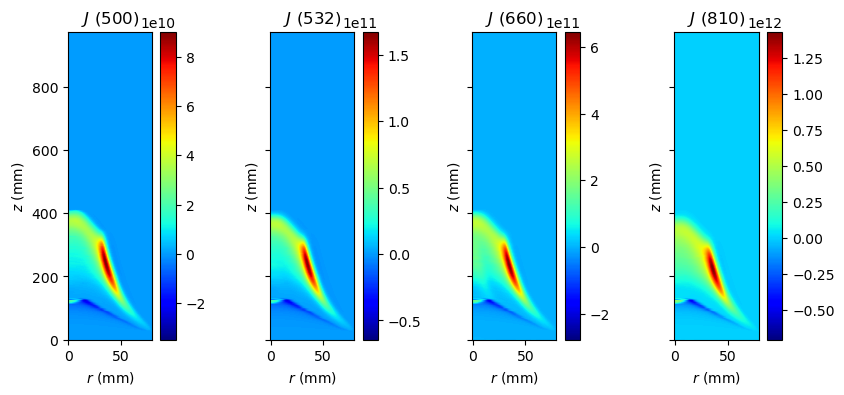

In [210]:
### figure
fig, axs = plt.subplots(1,len(lamb), sharex=True, sharey=True, figsize=(2.5*len(lamb),4))
for ii in range(len(lamb)):    
    im = axs[ii].imshow(J[:,:,ii], cmap='jet', aspect=0.3)
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$J~(' + str(lamb[ii]) + r')$' )
    axs[ii].set_xlabel(r'$r$ (mm)')
    axs[ii].set_ylabel(r'$z$ (mm)')
plt.show

""" fig, axs = plt.subplots(1,len(lamb), figsize=(2.5*len(lamb),4))
for ii in range(len(lamb)):    
    im = axs[ii].imshow(J_notSA[:,:,ii], cmap='jet', aspect=0.3)
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$J~notSA~(' + str(lamb[ii]) + r')$' )
    axs[ii].set_xlabel(r'$r$ (mm)')
    axs[ii].set_ylabel(r'$z$ (mm)')
plt.show """



<function matplotlib.pyplot.show(close=None, block=None)>

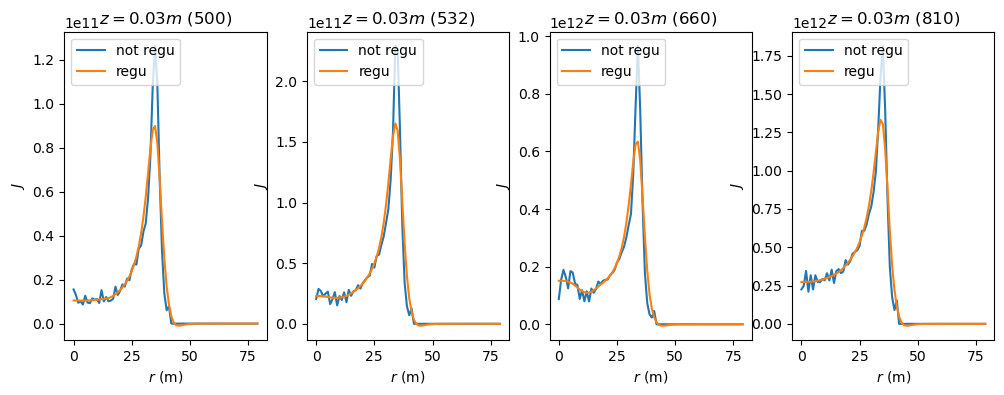

In [211]:
h = 0.030
# h_px = np.argmax(z>h)
### figure
fig, axs = plt.subplots(1,len(lamb), figsize=(3*len(lamb),4))
for ii in range(len(lamb)):
    axs[ii].plot(J_0[h_px,:,ii], label='not regu')
    axs[ii].plot(J[h_px,:,ii], label='regu')
    #axs[ii].plot(J_notSA[h_px,:,ii], label='regu notSA')
    #axs[ii].set_ylim([0, 12e11])
    #if ii == 0:    
    axs[ii].legend(loc='upper left')
    axs[ii].set_title(r'$z='+str(h)+'m~('+str(lamb[ii]) + r')$')
    axs[ii].set_xlabel(r'$r$ (m)')
    axs[ii].set_ylabel(r'$J$ ')
plt.show

C:\Users\claud\AppData\Local\Temp\ipykernel_16972\3213612451.py:14: RuntimeWarning: divide by zero encountered in true_divide
  A = np.divide(lambda_m[ii]**5*J[:,:,ii] , C1*Kext[:,:,ii]/np.pi)
C:\Users\claud\AppData\Local\Temp\ipykernel_16972\3213612451.py:14: RuntimeWarning: invalid value encountered in true_divide
  A = np.divide(lambda_m[ii]**5*J[:,:,ii] , C1*Kext[:,:,ii]/np.pi)
C:\Users\claud\AppData\Local\Temp\ipykernel_16972\3213612451.py:15: RuntimeWarning: invalid value encountered in log
  B = -lambda_m[ii]/C2*np.log(A)


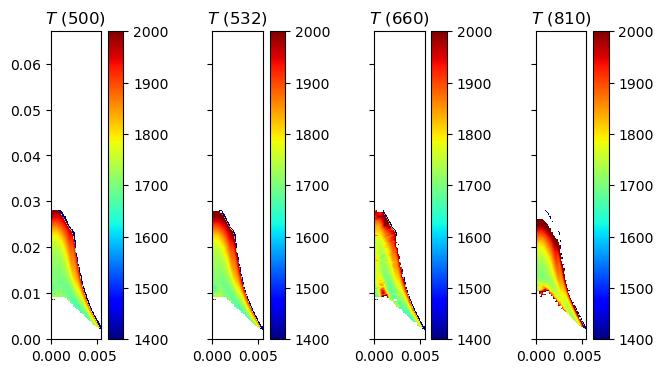

In [212]:
## Temperature calculation
## ========================
T_max = 2000
T_min = 1400
lambda_m = lamb_filters*1e-9 # Inputs

## 1 Color pyrometry
## -----------------
ifig += 1
Temp_1C = np.zeros(( nz,nx,len(lamb) ))
### figure
fig, axs = plt.subplots(1,len(lamb), sharex=True, sharey=True, figsize=(2*len(lamb),4))
for ii in range(len(lamb)): 
    A = np.divide(lambda_m[ii]**5*J[:,:,ii] , C1*Kext[:,:,ii]/np.pi)
    B = -lambda_m[ii]/C2*np.log(A)
    Temp_1C[:,:,ii] = np.divide(1,B)
    #   
    im = axs[ii].imshow(Temp_1C[:,:,ii],  vmin=T_min, vmax=T_max, cmap='jet', aspect=f_aspect, extent =[r.min(), r.max(), z.max(),  z.min()])
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$T~(' + str(lamb[ii]) + r')$' )
    #axs[ii].set_xlabel(r'$r$ (mm)')
    #axs[ii].set_ylabel(r'$z$ (mm)')
plt.show
if save_data == 1:    
    plt.savefig(folder_PYR + '/fields_Temp_1C_'+'alpha='+str(alfa_o)+'.png', dpi=300)




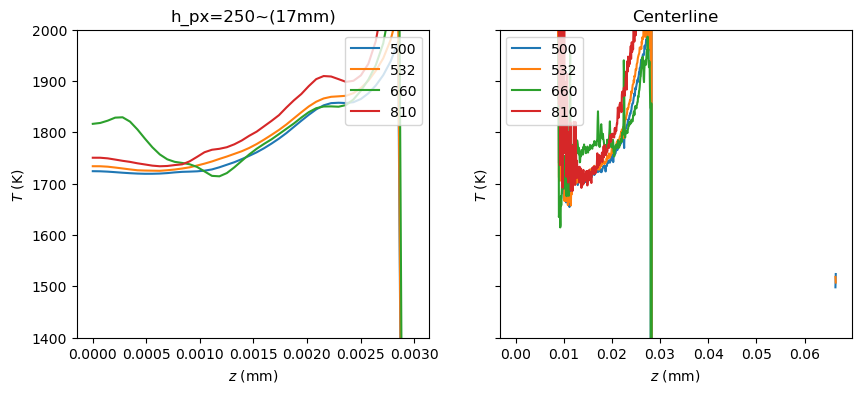

In [213]:
ifig += 1
fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,4))
for ii in range(len(lamb)):
    aux = Temp_1C[h_px,:,ii]
    axs[0].plot(r,aux , label=str(lamb[ii]))
    #axs[0].plot(r,18*Kext[h_px,:,ii] , label=str(lamb[ii]))
    axs[0].legend(loc='upper right')
    axs[0].set_ylim([T_min, T_max])
    axs[0].set_title('h_px='+str(h_px) +'~(' + str(round(1000*z[h_px])) + 'mm)' )
    axs[0].set_xlabel(r'$z$ (mm)')
    axs[0].set_ylabel(r'$T$ (K) ')
for ii in range(len(lamb)):
    aux = Temp_1C[:,0,ii]
    axs[1].plot(z,aux , label=str(lamb[ii]))
    axs[1].legend(loc='upper left')
    axs[1].set_ylim([T_min, T_max])
    axs[1].set_title('Centerline')
    axs[1].set_xlabel(r'$z$ (mm)')
    axs[1].set_ylabel(r'$T$ (K) ')
plt.show
if save_data == 1:  
    plt.savefig(folder_PYR + '/profiles_Temp_1C_'+'alpha='+str(alfa_o)+'.png', dpi=300)

[0]
[1]
[2]


C:\Users\claud\AppData\Local\Temp\ipykernel_16972\250060978.py:15: RuntimeWarning: invalid value encountered in true_divide
  div12 = np.divide(J[:,:,a],J[:,:,b])
C:\Users\claud\AppData\Local\Temp\ipykernel_16972\250060978.py:19: RuntimeWarning: invalid value encountered in log
  den12 = np.log( div12*(lamb[a]/lamb[b])**6 )


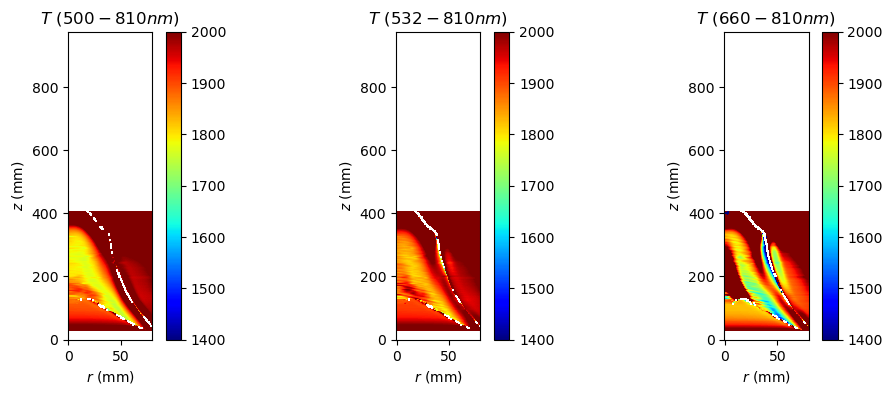

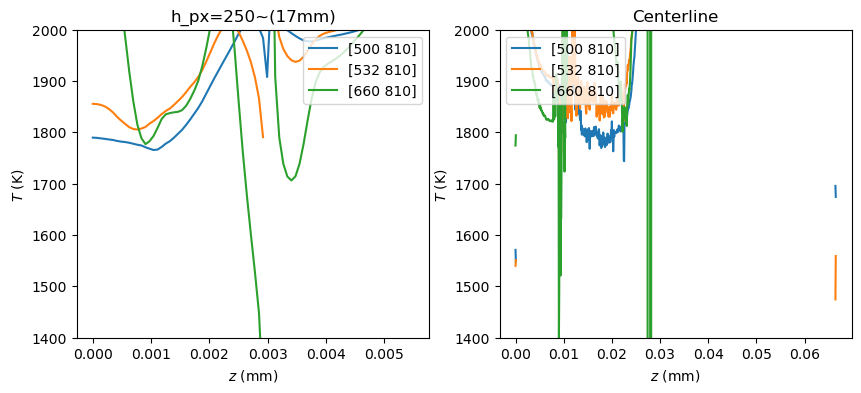

In [214]:
lamb_pair = np.array([ [500, 810], [532, 810], [660, 810] ]) #
Temp_2C = np.zeros(( nz,nx,len(lamb_pair[:,0]) ))

## Temperature 2C

ifig += 1
fig, axs = plt.subplots(1,len(lamb_pair[:,0]), figsize=(3*len(lamb),4))
for ii in range(len(lamb_pair[:,0])):
    a = np.where( lamb == lamb_pair[ii,0] )[0]
    print(a)
    b = np.where( lamb == lamb_pair[ii,1] )[0]
    a = int(a)
    b = int(b)
    num12 = -C2*(1e9/lamb[a]-1e9/lamb[b])
    div12 = np.divide(J[:,:,a],J[:,:,b])
    if Self_abs == 0: #  % For Emission pyrometry
        den12 = np.log( div12*(lamb[a]/lamb[b])**6*E_m[b]/E_m[a] )
    elif Self_abs == 1:  # For Mae (Consider the self absorption)
        den12 = np.log( div12*(lamb[a]/lamb[b])**6 )
        #den12 = np.log( np.multiply(div12,np.divide(Kext[:,:,b],Kext[:,:,a])) * (lamb[a]/lamb[b])**5 )
    Temp_2C[:,:,ii] = np.divide(num12,den12) # Soot temperature den12[:,:,0]
    #   
    im = axs[ii].imshow(Temp_2C[:,:,ii],  vmin=T_min, vmax=T_max, cmap='jet', aspect=0.3)
    fig.colorbar(im, ax=axs[ii])
    axs[ii].invert_yaxis()
    axs[ii].set_title(r'$T~(' + str(lamb[a]) + '-' + str(lamb[b]) + r'nm)$' )
    axs[ii].set_xlabel(r'$r$ (mm)')
    axs[ii].set_ylabel(r'$z$ (mm)')
if save_data == 1:
    plt.savefig(folder_PYR + '/fields_Temp_2C_'+'alpha='+str(alfa_o)+'.png', dpi=300)   

ifig += 1
fig, axs = plt.subplots(1,2, figsize=(10,4))
for ii in range(len(lamb_pair[:,0])):
    aux = Temp_2C[h_px,:,ii]
    axs[0].plot(r,aux , label=str(lamb_pair[ii,:]))
    axs[0].legend(loc='upper right')
    axs[0].set_ylim([T_min, T_max])
    axs[0].set_title('h_px='+str(h_px) +'~(' + str(round(1000*z[h_px])) + 'mm)' )
    axs[0].set_xlabel(r'$z$ (mm)')
    axs[0].set_ylabel(r'$T$ (K) ')
for ii in range(len(lamb_pair[:,0])):
    aux = Temp_2C[:,0,ii]
    axs[1].plot(z,aux , label=str(lamb_pair[ii,:]))
    axs[1].legend(loc='upper left')
    axs[1].set_ylim([T_min, T_max])
    axs[1].set_title('Centerline')
    axs[1].set_xlabel(r'$z$ (mm)')
    axs[1].set_ylabel(r'$T$ (K) ')
plt.show
if save_data == 1:     
    plt.savefig(folder_PYR + '/profiles_Temp_2C_'+'alpha='+str(alfa_o)+'.png', dpi=300)


In [215]:
lamb[int(a)]

660

In [216]:
### save data
gamma_cal = eta_losa_mean

if save_data == 1:
    np.savez(folder_PYR + '\Pyrometry_Temp_1C'+'alpha='+str(alfa_o)+'.npz',name_T_1C=Temp_1C, name_J=J, name_r=r, name_z=z, name_gamma=gamma_cal)
    np.savez(folder_PYR + '\Pyrometry_Temp_2C'+'alpha='+str(alfa_o)+'.npz',name_T_2C=Temp_2C, name_J=J, name_r=r, name_z=z, name_gamma=gamma_cal)
    np.savez(folder_PYR + '\Pyrometry_Temp_'+'alpha='+str(alfa_o)+'_'+str(round(z[h_px]*1e3,1)) + 'm_', name_J_30mm=J[h_px,:,:], name_Sy_cal_30mm=Sy_cal[h_px,:,:], name_Temp_1C_30mm=Temp_1C[h_px,:,:], name_Temp_2C_30mm=Temp_2C[h_px,:,:], name_r=r)

# J MC

In [217]:
activate_MC = 1
if activate_MC == 1:
    
    eta_losa_mean = np.zeros(len(lamb))
    eta_losa_std = np.zeros(len(lamb))
    Sy_cal = np.zeros((nz,nx,len(lamb),N_int))
    J_MC = np.zeros((nz,nx,len(lamb),N_int))
    for i in range(len(lamb)):
        eta_losa_mean[i] = np.mean(eta_losa[250:750,400:600,i]) #cte de calibracion
        eta_losa_std[i] = np.std(eta_losa[250:750,400:600,i])
        Sy_cal[:,:,i,:] = Py_MC[:,:,i,:]*eta_losa_mean[i]
        Py_lambd = Sy_cal[:,:,i,:] #? nz,nx,nMC
        dr = resol**-1 # radial resolution meter/pixel
        Self_abs = 1
        J_aux = np.zeros((nz,nx,N_int))
        print('inicia')
        J_aux,J_aux0,alfa = deconvolution_Py_MC(dr,alfa_o,Py_lambd,AUTOalfa,Self_abs,J_aux)    
        J_MC[:,:,i,:] = J_aux
        print(i)

    std_J = np.std(J_MC, axis=3)
    mean_J = np.mean(J_MC, axis=3)

    path_mean_J = os.path.join('results_MC', 'MC_10012023',OI,  'mean_J')
    path_std_J = os.path.join('results_MC', 'MC_10012023',OI, 'std_J')
    my_makedirs(path_mean_J)
    my_makedirs(path_std_J)
    np.save(path_mean_J,mean_J)
    np.save(path_std_J,std_J)

    # if save_data == 1:
    #     np.save(f'MC_{N_int}/{OI}/mean_J_MC',mean_J)
    #     np.save(f'MC_{N_int}/{OI}/std_J_MC',std_J)
    #     np.save(f'MC_{N_int}/{OI}/field_J_MC',J_MC)

    # np.save(os.path.join('results', 'MC', 'mean_J'),mean_J)
    # np.save(os.path.join('results', 'MC', 'std_J'),std_J)

inicia
0
inicia
1
inicia
2
inicia
3
path results_MC\MC_10012023\35\mean_J created
path results_MC\MC_10012023\35\std_J created


### J MC Nuevo

In [218]:
activate_MC = 0
Comentarios_iteraciones=False
if activate_MC == 1:
    eta_losa_mean = np.zeros(len(lamb))
    eta_losa_std = np.zeros(len(lamb))
    Sy_cal = np.zeros((nz,nx,len(lamb),N_int))
    J_MC = np.zeros((nz,nx,len(lamb),N_int))


    eta_losa_mean[:] = np.mean(eta_losa[250:750,400:600,:], axis=(0,1)) #cte de calibracion
    eta_losa_std[:] = np.std(eta_losa[250:750,400:600,:], axis=(0,1))
    #? Py_MC.shape = 976,80,4,75
    #? Py_lambd.shape = nz,nr,lambd,N_int
    # Sy_cal[:,:,i,:] = Py_MC[:,:,i,:]*eta_losa_mean[i]
    Sy_cal[:,:,:,:] = np.einsum('ijkl,k -> ijkl',Py_MC,eta_losa_mean)
    Py_lambd = Sy_cal[:,:,:,:]
    dr = resol**-1 # radial resolution meter/pixel
    Self_abs = 1
    J_aux = np.zeros_like(Py_lambd)
    J_aux,J_aux0,alfa = new_deconvolution_Py_MC(dr,alfa_o,Py_lambd,AUTOalfa,Self_abs,kext_MC,Comentarios_iteraciones)    
    J_MC[:,:,:,:] = J_aux

    std_J = np.std(J_MC, axis=3)
    mean_J = np.mean(J_MC, axis=3)
    if save_data == 1:
        np.save(f'MC_{N_int}/{OI}/mean_J_MC', mean_J)
        np.save(f'MC_{N_int}/{OI}/std_J_MC', std_J)
        np.save(f'MC_{N_int}/{OI}/field_J_MC', J_MC)

In [219]:
%matplotlib inline

def plot_pdf_kext(i_z,i_r,i_lambd):
       fig, ax = plt.subplots(1,2, figsize=(8,3))
       mu = mean_J[i_z,i_r,i_lambd]
       sigma = std_J[i_z,i_r,i_lambd]
       test = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
       # test = np.linspace(stats.norm.ppf(0.01),
       #                 stats.norm.ppf(0.99), 100)
       ax[0].plot(test, stats.norm.pdf(test, mu, sigma),
              'r-', lw=5, alpha=0.6, label='norm pdf')
       ax[0].set_xlim(-1e11,1e11)
       im = ax[1].contourf(r,z,std_J[:,:,i_lambd], levels = 100)
       ax[1].plot(r[i_r],z[i_z],'s', color = 'red')
       cbar = CreateAndLocateColorbar(im, ax[1], fig)

       plt.show()

In [220]:
i_z_widget = widgets.IntSlider(min=0, max= 975, step=1, value=0)
i_r_widget = widgets.IntSlider(min=0, max= 80, step=1, value=0)
i_l_widget = widgets.IntSlider(min=0, max= 3, step=1, value=0)

widgets.interact(plot_pdf_kext, i_z = i_z_widget, i_r = i_r_widget, i_lambd = i_l_widget)

interactive(children=(IntSlider(value=0, description='i_z', max=975), IntSlider(value=0, description='i_r', ma…

<function __main__.plot_pdf_kext(i_z, i_r, i_lambd)>